In [1]:
#
# 2017-08-31
#
# XGB - решение - дурняк, но работает
#
#
#

In [2]:
import sys, os, math, datetime
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
def dataClean( df ) :
    def cn (cc) : 
        cc = np.reshape(cc.values,(len(df)))
        return([jj for jj,dd in enumerate(cc.tolist()) if dd ])
    ##df=df.fillna(0.0)
    badly = np.zeros((len(df)),dtype=np.int32)
    ##cols  = df.columns.tolist()
    ##print(cols)
    for ii,nn in enumerate(df.columns.tolist()) :
        
        if (ii==0) and (nn.startswith('Chloro')) : # Chlorophyl
            cc = ((df[[ii]]<0.0) | (df[[ii]]>1.0))
            df.iloc[cn(cc),ii] = 0.0
            #badly[cn(cc)] += 1
        
        if (ii==1) and (nn.startswith('Depth')) : 
            cc = (df[[ii]]> 0.0);      df.iloc[cn(cc),ii] = -df.iloc[cn(cc),ii]
            cc = (df[[ii]]< -10000.0); df.iloc[cn(cc),ii] = -10000.0
            badly[cn(cc)] += 1
        
        if (ii==3) and (nn.startswith('Eastward')) :
            cc = (df[[ii]]< 0.0);      df.iloc[cn(cc),ii] = 0.0
            cc = (df[[ii]]> 5.0);      df.iloc[cn(cc),ii] = 5.0
            badly[cn(cc)] += 1
        
        if (ii==4) and (nn.startswith('Latitude')) :
            cc = (df[[ii]]< -90.0);      df.iloc[cn(cc),ii] = -90.0; badly[cn(cc)] += 1
            cc = (df[[ii]]>  90.0);      df.iloc[cn(cc),ii] =  90.0; badly[cn(cc)] += 1
        
        if (ii==5) and (nn.startswith('Longitude')) :
            cc = (df[[ii]]< -180.0);      df.iloc[cn(cc),ii] = -180.0; badly[cn(cc)] += 1
            cc = (df[[ii]]>  180.0);      df.iloc[cn(cc),ii] =  180.0; badly[cn(cc)] += 1
        
        if (ii==6) and (nn.startswith('Northward')) :
            cc = (df[[ii]]< 0.0);      df.iloc[cn(cc),ii] = 0.0
            cc = (df[[ii]]> 5.0);      df.iloc[cn(cc),ii] = 5.0
            badly[cn(cc)] += 1
        
        if (ii==7) and (nn.startswith('Oceanic')) : 
            cc = (df[[ii]]> 0.0);      df.iloc[cn(cc),ii] = -df.iloc[cn(cc),ii]
            cc = (df[[ii]]< -10000.0); df.iloc[cn(cc),ii] = -10000.0
            badly[cn(cc)] += 1
        
        if (ii==8) and (nn.startswith('SOG')) : 
            cc = (df[[ii]]<  0.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
            cc = (df[[ii]]> 35.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
        
        if (ii==9) and (nn.startswith('Salinity')) : 
            cc = (df[[ii]]<  0.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
            #cc = (df[[ii]]> 35.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
        
        if (ii==10) and (nn.startswith('Sea')) : 
            cc = (df[[ii]]<  0.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
            #cc = (df[[ii]]> 35.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
        
        if (ii==11) and (nn.startswith('Speed')) : 
            cc = (df[[ii]]<  0.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
            cc = (df[[ii]]> 35.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1

        if (ii==11) and (nn.startswith('Thermocline')) : 
            cc = (df[[ii]]<     0.0);      df.iloc[cn(cc),ii] =     0.0; badly[cn(cc)] += 1
            cc = (df[[ii]]>  5000.0);      df.iloc[cn(cc),ii] =  5000.0; badly[cn(cc)] += 1

        if (ii==15) and (nn.startswith('Water')) : 
            cc = (df[[ii]]<  -100.0);      df.iloc[cn(cc),ii] =     0.0; badly[cn(cc)] += 1
            #cc = (df[[ii]]>  5000.0);      df.iloc[cn(cc),ii] =  5000.0; badly[cn(cc)] += 1

    print(cc.sum(),badly.sum())
    return(badly)

In [4]:
# Читаем train список
train_list = pd.read_csv('../Data/training.txt', header=None)
train_list.columns=['trackfile','typing']

In [5]:
train_list.head()

,trackfile,typing
0,100047,trawler
1,100070,longliner
2,100080,seiner
3,100093,other
4,100144,trawler


In [6]:
y_class = train_list['typing'].unique().tolist(); y_class

['trawler', 'longliner', 'seiner', 'other', 'support']

In [7]:
# Читаем test список
test_list = pd.read_csv('../Data/testing.txt', header=None)
test_list.columns=['trackfile']
print 'test length:',len(test_list)
test_list.head()

test length: 1211


,trackfile
0,100015
1,100045
2,100060
3,100112
4,100131


In [1014]:
# Построение массива с данными по списку файлов

def buildX (file_list, nFiles=-1, maxSpeed=35.0, maxSOG=35.0, rWindow=5, hTimeMin=False, hTimeMax=False, fillOK=False) :
    
    
    for ii,ffile in enumerate(file_list) :
        if ii==nFiles : break
        xx = pd.read_csv(os.path.join('../Data/VesselTracks',str(ffile)+'.csv'))
        
        ##print(ii,ffile)
        
        # Small corrections: (latitude&longitude), timing
        
        xx = xx[(xx.Latitude >=-90.0)  & (xx.Latitude <= 90.0)];
        xx = xx[(xx.Longitude>=-180.0) & (xx.Longitude<=180.0)];
        
        xx['Time']  = xx[[1]]
        xx['sTime'] = np.abs(xx.Time.diff(-1)).fillna(0.0)
        xx['hTime'] = xx.sTime/3600.0
        
        if hTimeMin : 
            xx          = xx[xx.hTime>=hTimeMin]
            xx['sTime'] = np.abs(xx.Time.diff(-1)).fillna(0.0)
            xx['hTime'] = xx.sTime/3600.0
            
        havLa       = (0.5*(1.0-np.cos(-xx.Latitude.diff(-1)/180.0*math.pi))).fillna(0.0)
        lLongitude  = xx.Longitude+360.0
        havLo       = (0.5*(1.0-np.cos(-lLongitude.diff(-1)/180.0*math.pi))).fillna(0.0)

        cosLa       = (np.cos(xx.Latitude/180.0*math.pi)).fillna(0.0)

        hav         = (havLa+cosLa*cosLa.shift(-1)*havLo).fillna(0.0)
        dist = (2*6371.0*np.arcsin(np.sqrt(hav))).fillna(0.0)

        xx['Distance'] = dist
        xx['Speed']    = np.round((dist/1.852/xx.hTime).fillna(0.0),2)
        xx.loc[xx.Speed>maxSpeed,'Speed'] = maxSpeed
        
        if hTimeMax : 
            xx.sTime[xx.hTime<=hTimeMax] = 0.0
            xx.hTime[xx.hTime<=hTimeMax] = 0.0
        
        # rolling Speed
        rSOG      = xx.SOG.rolling(window=rWindow, min_periods=1).mean()
        rSOGmd    = xx.SOG.rolling(window=rWindow, min_periods=1).median()
        rSpeed    = xx.Speed.rolling(window=rWindow, min_periods=1).mean()
        rDistance = xx.Distance.rolling(window=rWindow, min_periods=1).mean()
        rTime     = xx.hTime.rolling(window=rWindow, min_periods=1).mean()
        rDTSpeed = (rDistance/rTime/1.852).fillna(0.0)
        
        xx['rSpeed'] = np.round(np.clip(rSpeed,0.0,maxSpeed),2)
        xx['rSOG']   = np.round(np.clip(rSOG,0.0,maxSpeed),2)
        xx['rSOGmd'] = np.round(np.clip(rSOGmd,0.0,maxSpeed),2)
        xx['rDTSpeed'] = np.round(np.clip(rDTSpeed,0.0,maxSpeed),2)
        
        xx.loc[xx.SOG>maxSOG,'SOG'] = xx.loc[xx.SOG>maxSOG,'rSOG']
        xx.loc[xx.SOG<0.0,'SOG']    = xx.loc[xx.SOG<0.0,'rSOG']

        if fillOK : xx = xx.fillna(fillOK)

        if (ii==0) : resAll = xx.copy()
        else       : resAll = resAll.append(xx.copy())

    ##print(trainAll.shape)
    return (resAll)

def buildY (file_list, y_classes) :
    
    trainIndex=file_list.copy()
    trainIndex['y'] = np.array(map(y_classes.index,trainIndex.typing.tolist()))
    return(trainIndex)

In [544]:
print datetime.datetime.now()
trainAll_ = buildX(train_list['trackfile'].values.tolist(), nFiles=12) #, hTimeMin=5.0/3600);
temp      = '\tLatitudes: between {} and {} \n\tLongitudes: between {} and {} \n\tFiles={} Shapes={}'
print(temp.format(trainAll_.Latitude.min(), trainAll_.Latitude.max(), trainAll_.Longitude.min(), 
                  trainAll_.Longitude.max(), len(trainAll_.TrackNumber.unique()),  trainAll_.shape))
print datetime.datetime.now()
##len(trainAll_.TrackNumber.unique()),trainAll_.TrackNumber.unique(),trainAll_.tail()

2017-09-04 01:39:50.834822
	Latitudes: between -67.458415 and 56.720937 
	Longitudes: between -179.67688 and 179.980242 
	Files=12 Shapes=(68343, 19)
2017-09-04 01:39:51.104943


In [545]:
trainAll_.describe()

,TrackNumber,Time(seconds),Latitude,Longitude,SOG,oceanic depth,Chlorophyll Concentration,Salinity,Water Surface Elevation,Sea Temperature,Thermocline Depth,Eastward Water Velocity,Northward Water Velocity,Time,sTime,hTime,Distance,Speed,rSpeed
count,68343.000000,6.834300e+04,68343.000000,68343.000000,68343.000000,68343.000000,68343.000000,68343.000000,68343.000000,68343.000000,68343.000000,68343.000000,68343.000000,6.834300e+04,6.834300e+04,68343.000000,68343.000000,68343.000000,68343.000000
mean,100177.603003,3.823745e+06,39.738107,-19.413192,1.510658,-208.938823,-44208.527856,30.038326,-5.191575,4.830204,169.833471,-4.268868,-4.348623,3.823745e+06,1.355213e+03,0.376448,3.105737,2.578414,7.250289
std,79.937088,2.384120e+06,20.018974,79.004114,382.551771,421.545481,49663.762562,662.754271,662.521443,662.693920,667.332902,662.526826,662.526270,2.384120e+06,1.697947e+04,4.716520,133.617179,4.445773,11.243540
min,100047.000000,0.000000e+00,-67.458415,-179.676880,-99999.000000,-1532.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,100093.000000,1.544225e+06,37.388433,-9.366658,0.000000,-76.000000,-99999.000000,34.000000,-1.760000,-0.800000,136.100000,-0.060000,-0.100000,1.544225e+06,6.100000e+01,0.016944,0.001481,0.010000,0.020000
50%,100144.000000,4.021559e+06,51.415543,8.310493,0.100000,-5.000000,0.145500,34.200000,-1.370000,1.400000,169.000000,0.150000,0.050000,4.021559e+06,4.050000e+02,0.112500,0.004308,0.050000,0.670000
75%,100277.000000,5.945117e+06,53.993879,8.709229,3.600000,0.000000,0.683000,34.700000,-0.010000,14.400000,173.800000,0.310000,0.150000,5.945117e+06,9.300000e+02,0.258333,0.360720,3.200000,9.910000
max,100287.000000,7.948470e+06,56.720937,179.980242,16.800000,132.000000,3.902200,35.800000,0.770000,31.300000,1109.600000,1.160000,1.040000,7.948470e+06,2.163149e+06,600.874722,12436.947142,35.000000,35.000000


In [1015]:
print datetime.datetime.now()
trainAll_ = buildX(train_list['trackfile'].values.tolist(), hTimeMin=2.0/(60.0*60.0));
temp      = '\tLatitudes: between {} and {} \n\tLongitudes: between {} and {} \n\tFiles={} Shapes={}'
print(temp.format(trainAll_.Latitude.min(), trainAll_.Latitude.max(), trainAll_.Longitude.min(), 
                  trainAll_.Longitude.max(), len(trainAll_.TrackNumber.unique()),  trainAll_.shape))
trainAll  = trainAll_
trainAll.to_csv('../Data/trainingAllNew.csv',index=False)
del trainAll_
print datetime.datetime.now()

2017-09-05 02:25:47.457848
	Latitudes: between -89.798397 and 89.64788 
	Longitudes: between -179.999883 and 179.999953 
	Files=1209 Shapes=(7338688, 23)
2017-09-05 02:37:20.750929


In [1016]:
len(train_list['trackfile'].values.tolist())

1209

In [1017]:
trainAll = pd.read_csv('../Data/trainingAllNew.csv')

In [1018]:
#trainWeights = dataClean(trainAll)

In [1019]:
!ls -la ../Data
trainAll.shape

total 4057872
drwxrwxrwx 1 boba boba       4096 сен  4 03:08 .
drwxrwxrwx 1 boba boba       4096 сен  1 16:12 ..
-rwxrwxrwx 1 boba boba  973453918 сен  2 02:54 testingAll.csv
-rwxrwxrwx 1 boba boba  850738365 сен  4 03:08 testingAllNew.csv
-rwxrwxrwx 1 boba boba       8477 авг 25 23:42 testing.txt
-rwxrwxrwx 1 boba boba 1195264916 сен  2 01:53 trainingAll.csv
-rwxrwxrwx 1 boba boba 1135229204 сен  5 02:37 trainingAllNew.csv
-rwxrwxrwx 1 boba boba      18151 авг 25 23:40 training.txt
drwxrwxrwx 1 boba boba     528384 авг 26 00:37 VesselTracks


(7338688, 23)

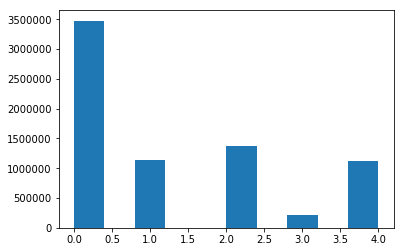

,TrackNumber,Chlorophyll Concentration,Distance,Eastward Water Velocity,Latitude,Longitude,Northward Water Velocity,Oceanic Depth,SOG,Salinity,...,Time(seconds),Water Surface Elevation,hTime,oceanic depth,rDTSpeed,rSOG,rSOGmd,rSpeed,sTime,y
0,100047,0.3105,3.186329,0.06,41.101078,1.235355,0.01,NaN,7.4,34.3,...,0,-0.22,0.258611,-4.0,6.65,7.40,7.40,6.65,931.0,0
1,100047,0.3043,5.981159,0.06,41.074507,1.221120,0.02,NaN,5.1,34.3,...,931,-0.22,0.358333,-11.0,8.02,6.25,6.25,7.83,1290.0,0
2,100047,0.3059,8.779740,0.06,41.043652,1.279553,0.04,NaN,10.2,34.3,...,2221,-0.23,0.458889,-16.0,9.01,7.57,7.40,8.66,1652.0,0
3,100047,0.3674,0.000095,0.08,40.998603,1.365502,0.07,NaN,10.5,34.3,...,3873,-0.24,0.001111,-46.0,9.00,8.30,8.80,6.51,4.0,0
4,100047,0.3674,7.221329,0.08,40.998602,1.365502,0.07,NaN,10.5,34.3,...,3877,-0.24,0.393056,-46.0,9.24,8.74,10.20,7.19,1415.0,0


In [1020]:
trainIndex = buildY(train_list,y_class)
train      = trainAll.set_index('TrackNumber')
train['y'] = trainIndex.set_index('trackfile').y
train      = train.reset_index()
plt.hist(train.y); plt.show(); plt.close()
train.head()

In [1021]:
hTimeMin = 3.0/3600.0
hTimeMax = 48.0

OKtrain = ((train.hTime<=hTimeMax) & (train.hTime>hTimeMin))
NOtrain = np.logical_not(OKtrain)

In [1022]:
import xgboost as xgb

In [1023]:
train_x = train.drop(['y','TrackNumber','Time','Time(seconds)'],axis=1)  #[:1000000]
train_y = train.y.values  #[:1000000]

mtrain = xgb.DMatrix(train_x,label=train_y)

In [1024]:
# Добавляем веса, чтобы не удалять записи из массива
if 0 :
    temp = (0.0+train_x.shape[1]-1.5*trainWeights)/train_x.shape[1]
    mtrain.set_weight(temp)
    trainWeights.min(), trainWeights.max()
    plt.hist(temp,bins=50); plt.show()
    temp.min(),temp.max(), train_x.shape, trainWeights.min(), trainWeights.max()

In [1025]:
train_y.shape, train_x.shape, train_x.columns.tolist(), train_y.max()

((7338688,),
 (7338688, 20),
 ['Chlorophyll Concentration',
  'Distance',
  'Eastward Water Velocity',
  'Latitude',
  'Longitude',
  'Northward Water Velocity',
  'Oceanic Depth',
  'SOG',
  'Salinity',
  'Sea Temperature',
  'Speed',
  'Thermocline Depth',
  'Water Surface Elevation',
  'hTime',
  'oceanic depth',
  'rDTSpeed',
  'rSOG',
  'rSOGmd',
  'rSpeed',
  'sTime'],
 4)

In [1026]:
##import sklearn as sk
##from sklearn.model_selection import cross_val_score

In [1027]:
##cross_val_score(estimator=xgb.XGBClassifier(), X=train_x, y=train_y, cv=5, scoring='accuracy')

In [1028]:
parms = {'reg':'logistic'}
parms = {'multi':'softmax','num_class':5,'metrics':'mlogloss'}
#parms = {'num_class':5,'metrics':'mlogloss'}
parms['objective'] = 'multi:softprob'
parms['eval_metric'] = ['merror','mlogloss']
parms['silent'] = 0

evallist  = [(mtrain,'train')]
##parms = {'reg':'logistic'}
##parms = {'reg':'linear','metrics':'auc'}

##hhcv  = xgb.cv(parms,mtrain,num_boost_round=400,nfold=5,early_stopping_rounds=4,verbose_eval=True,metrics=['merror','mlogloss'])
#hist = xgb.train(parms,mtrain,num_boost_round=30,early_stopping_rounds=5)

In [706]:
hhcv

,test-merror-mean,test-merror-std,test-mlogloss-mean,test-mlogloss-std,train-merror-mean,train-merror-std,train-mlogloss-mean,train-mlogloss-std
0,0.185543,0.001631,1.184000,0.000665,0.185468,0.001425,1.183974,0.000566
1,0.177706,0.000731,0.964420,0.000939,0.177727,0.000833,0.964356,0.000816
2,0.169069,0.001076,0.821264,0.001090,0.168964,0.000995,0.821160,0.000828
3,0.163024,0.000766,0.719096,0.000832,0.162966,0.000857,0.718979,0.000584
4,0.158126,0.001351,0.641246,0.000798,0.158054,0.001411,0.641076,0.000605
5,0.153794,0.001738,0.582834,0.000868,0.153730,0.001778,0.582647,0.001081
6,0.150526,0.002095,0.537238,0.000714,0.150471,0.002122,0.537051,0.000732
7,0.146832,0.000914,0.501902,0.001138,0.146795,0.001026,0.501682,0.000916
8,0.143973,0.001246,0.474114,0.001246,0.143944,0.001252,0.473868,0.000946
9,0.140727,0.002129,0.450779,0.001568,0.140716,0.002052,0.450528,0.001353


In [1030]:
#xgbmodel = xgb.train(parms,mtrain,num_boost_round=1) # empty nodel

In [1031]:
print datetime.datetime.now()
xgbmodel = xgb.train(parms,mtrain,num_boost_round=200, evals=evallist) #, xgb_model=xgbmodel) # = 400
print datetime.datetime.now()

2017-09-05 02:42:16.226621
[0]	train-merror:0.187147	train-mlogloss:1.1816
[1]	train-merror:0.173083	train-mlogloss:0.961093
[2]	train-merror:0.164596	train-mlogloss:0.817401
[3]	train-merror:0.162422	train-mlogloss:0.715057
[4]	train-merror:0.155083	train-mlogloss:0.636561
[5]	train-merror:0.14924	train-mlogloss:0.576858
[6]	train-merror:0.145513	train-mlogloss:0.531279
[7]	train-merror:0.142636	train-mlogloss:0.495885
[8]	train-merror:0.140815	train-mlogloss:0.469056
[9]	train-merror:0.137775	train-mlogloss:0.44616
[10]	train-merror:0.135124	train-mlogloss:0.427413
[11]	train-merror:0.133012	train-mlogloss:0.41279
[12]	train-merror:0.13132	train-mlogloss:0.399059
[13]	train-merror:0.12879	train-mlogloss:0.385246
[14]	train-merror:0.125597	train-mlogloss:0.372757
[15]	train-merror:0.123296	train-mlogloss:0.363431
[16]	train-merror:0.120703	train-mlogloss:0.353529
[17]	train-merror:0.118732	train-mlogloss:0.345915
[18]	train-merror:0.116622	train-mlogloss:0.339279
[19]	train-merror:0.1

In [1032]:
#xgbmodel.load_model('../Work/xgbModel.bst')
##xgbmodel.load_model('../Work/xgbModelClean.bst')
##xgbmodel.save_model('../Work/xgbModelCleanSoftProb.bst')
##xgbmodel.save_model('../Work/xgbModel-NotClean-SoftProb-200.bst')
#xgbmodel.save_model('../Work/xgbModel-NotClean-SoftProb-400.bst')
#xgbmodel = xgb.Booster()
#xgbmodel.load_model('../Work/xgbModel-NotClean-SoftProb-400.bst')
xgbmodel.save_model('../Work/xgbModel-NotClean-SoftProb-New2-200.bst')

In [1033]:
pred_y = xgbmodel.predict(mtrain); ##pred_y[-20:],pred_y.max()

In [1034]:
pred_y.shape, pred_y.max() #pred_y[:4]

((7338688, 5), 1.0)

In [1035]:
pred_y_softmax=pred_y.argmax(axis=1); pred_y_softmax.shape

(7338688,)

In [1037]:
((pred_y_softmax==train_y).sum()/float(len(pred_y)))

0.96573188559044887

In [1038]:
df_diff = pd.DataFrame(train.TrackNumber,columns=['TrackNumber'])
df_diff['true_y'] = np.array(train_y,dtype=np.uint8)
df_diff['pred_y'] = np.array(pred_y_softmax, dtype=np.uint8)

df_diff['OK']    = df_diff.true_y==df_diff.pred_y

#print(df_diff.head())

len(df_diff)-df_diff.OK.sum()
aa = df_diff.groupby(['TrackNumber','OK']).size().reset_index(); aa.columns=['TrackNumber','OK','ccount']; aa.head()
bb = pd.DataFrame(train.TrackNumber.unique(),columns=['TrackNumber'])
bb['xx'] = 1.0; bb=bb.set_index(['TrackNumber'])
cc = aa[['TrackNumber','ccount']][aa.OK==True];  cc.head(); cc = cc.set_index(['TrackNumber']); bb['Yes']=cc
cc = aa[['TrackNumber','ccount']][aa.OK==False]; cc.head(); cc = cc.set_index('TrackNumber'); bb['No'] =cc
bb=bb.reset_index().drop('xx',axis=1).fillna(0)
print(bb.head())
float(len(bb[bb.No>bb.Yes]))/len(bb)*100.0

   TrackNumber      Yes     No
0       100047    650.0    0.0
1       100070    283.0  113.0
2       100080   9717.0   45.0
3       100093   5406.0   97.0
4       100144  15427.0    0.0


2.481389578163772

In [1039]:
#trainAll.describe()

In [1040]:
#testAll.describe()

In [1042]:
fimp  = xgbmodel.get_fscore();
ffimp = [[k,fimp[k]] for k in fimp.keys()]; 
ffimp.sort(key=lambda x: x[1],reverse=True)
tempsum = 0
for temp in ffimp : tempsum+=temp[1];
##print(tempsum)
for ii,temp in enumerate(ffimp) : 
    ffimp[ii][1] = float(ffimp[ii][1])/tempsum*100.0;
ffimp

[['Longitude', 14.804406279816115],
 ['Latitude', 12.826784630063317],
 ['Oceanic Depth', 11.43724520773701],
 ['Sea Temperature', 5.939803972590858],
 ['Water Surface Elevation', 5.922456414259693],
 ['Chlorophyll Concentration', 5.82531008760517],
 ['Eastward Water Velocity', 5.662243039292219],
 ['Salinity', 4.937115101049527],
 ['Thermocline Depth', 4.886807181889149],
 ['Northward Water Velocity', 4.725474889409316],
 ['rSOGmd', 4.215456674473068],
 ['rDTSpeed', 3.7748286928614796],
 ['rSOG', 3.3879781420765025],
 ['SOG', 2.6177465521727816],
 ['oceanic depth', 2.3141642813773964],
 ['rSpeed', 2.0071124989157774],
 ['hTime', 1.7330210772833723],
 ['Distance', 1.6081186572989852],
 ['Speed', 1.3739266198282591]]

In [1043]:
y_class, trainIndex[trainIndex.trackfile==100093].typing

(['trawler', 'longliner', 'seiner', 'other', 'support'], 3    other
 Name: typing, dtype: object)

In [1044]:
hTimeMin = 10.0/3600.0
hTimeMax = 48.0

OKtrain = ((train.hTime<=hTimeMax) & (train.hTime>hTimeMin))
NOtrain = np.logical_not(OKtrain)

In [1046]:
if 0 :
    train_o          = train.copy()
    pred_y_o         = pred_y.copy()
    pred_y_softmax_o = pred_y_softmax.copy()
if 0 :
    train            = train_o.copy()
    pred_y           = pred_y_o.copy()
    pred_y_softmax   = pred_y_softmax_o.copy()
len(train), len(pred_y), len(pred_y_softmax), train.shape

(7338688, 7338688, 7338688, (7338688, 24))

In [1047]:
if 0 :
    train          = train[OKtrain]
    pred_y         = pred_y[OKtrain]
    pred_y_softmax = pred_y_softmax[OKtrain]

In [1048]:
len(train), len(pred_y), len(pred_y_softmax)

(7338688, 7338688, 7338688)

    TrackNumber  pred_y        pr
0        100047       0  1.000000
1        100070       1  0.714646
2        100070       2  0.285354
3        100080       2  0.995390
4        100080       4  0.004610
5        100093       0  0.017627
6        100093       3  0.982373
7        100144       0  1.000000
8        100161       0  0.000342
9        100161       1  0.999658
10       100175       0  0.999773
11       100175       1  0.000227
12       100204       0  0.948268
13       100204       1  0.042326
14       100204       2  0.005985
15       100204       3  0.003420
16       100216       0  0.008904
17       100216       3  0.991096
18       100262       0  1.000000
19       100277       1  0.000722


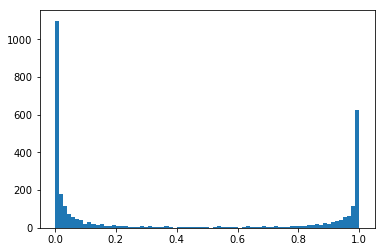

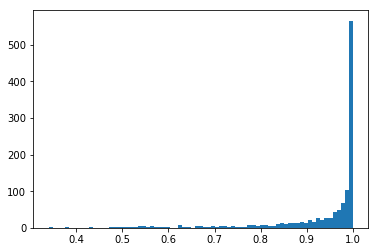

38

In [1049]:
ppred = pd.DataFrame()
ppred['TrackNumber'] = train.TrackNumber
ppred['pred_y']      = pred_y_softmax
ppred['true_y']      = train.y

g0pred = ppred.groupby(['TrackNumber','pred_y']).size()
g1pred = ppred.groupby(ppred.TrackNumber).size(); #print(len(g1pred),g1pred.head())
temp   = np.round(g0pred/g1pred,6)
g0pred = g0pred.reset_index()
g0pred.columns = ['TrackNumber','pred_y','pr']
g0pred['pr'] = temp.values
'''
g0pred = g0pred.set_index(['TrackNumber','pred_y']).unstack(level=-1).fillna(0.0); 
g0pred.columns=[0,1,2,3,4]
print(g0pred.head(20)) #,g0pred.columns)
if 1 :
    for nn in g0pred.columns : g0pred[nn][g0pred[nn]<=0.05] = 0.0;
    temp     = g0pred.sum(axis=1); temp.shape #, g100pred.shape; g100pred,temp.head()
    for nn in g0pred.columns : g0pred[nn] = np.round(g0pred[nn]/temp,6);

temp = g0pred.stack().fillna(0.0)
temp = temp[temp>0.0]
g0pred = temp.reset_index()
g0pred.columns = ['TrackNumber','pred_y','pr']
'''
print(g0pred.head(20))

g2pred = g0pred.reset_index()
g2pred = g2pred.pr.groupby(g2pred.TrackNumber).max()
plt.hist(g0pred.pr,bins=75); plt.show()
plt.hist(g2pred,bins=75); plt.show()
#g0pred
g2pred.head()
len(g2pred[g2pred<0.60])

In [1050]:
#Построение train-решения через probs без времени, только частотность

g100     = pd.DataFrame(pred_y); g100.head(), g100.columns
g100pred = g100.groupby(ppred.TrackNumber).sum(); g100pred.head()
temp     = g100pred.sum(axis=1); temp.shape #, g100pred.shape; g100pred,temp.head()
for nn in g100pred.columns : g100pred[nn] = np.round(g100pred[nn]/temp,6); 
g100pred.head()
if 1 :
    for nn in g100pred.columns : g100pred[nn][g100pred[nn]<=0.05] = 0.0;
    temp     = g100pred.sum(axis=1); temp.shape #, g100pred.shape; g100pred,temp.head()
    for nn in g100pred.columns : g100pred[nn] = np.round(g100pred[nn]/temp,6);

temp = g100pred.stack()
temp = temp[temp>0.0]
g100pred = pd.DataFrame(temp.reset_index());
g100pred.columns=['TrackNumber','pred_y','pr']
del temp
g100pred.head(30), g100pred.pred_y.dtype

(    TrackNumber  pred_y        pr
 0        100047       0  1.000000
 1        100070       1  0.606213
 2        100070       2  0.393787
 3        100080       2  1.000000
 4        100093       3  1.000000
 5        100144       0  1.000000
 6        100161       1  1.000000
 7        100175       0  1.000000
 8        100204       0  0.879566
 9        100204       1  0.120434
 10       100216       0  0.050303
 11       100216       3  0.949697
 12       100262       0  1.000000
 13       100277       2  1.000000
 14       100287       0  1.000000
 15       100305       0  1.000000
 16       100321       0  0.888019
 17       100321       1  0.057643
 18       100321       3  0.054338
 19       100362       1  0.476103
 20       100362       2  0.523897
 21       100370       0  1.000000
 22       100380       2  0.913713
 23       100380       4  0.086287
 24       100383       0  0.107041
 25       100383       1  0.070363
 26       100383       2  0.822596
 27       100403    

In [1051]:
g110     = pd.DataFrame(pred_y) # в работе время 
for nn in g110.columns : g110[nn] = np.round(g110[nn]*0.5*(train.sTime+train.sTime.shift().fillna(0.0)),6);
    
g110pred = g110.groupby(ppred.TrackNumber).sum(); g110pred.head()
temp     = g110pred.sum(axis=1); temp.shape #, g110pred.shape; g110pred,temp.head()
for nn in g110pred.columns : g110pred[nn] = np.round(g110pred[nn]/temp,6);
if 1 :
    for nn in g110pred.columns : g110pred[nn][g110pred[nn]<=0.05] = 0.0;
    temp     = g110pred.sum(axis=1); temp.shape #, g110pred.shape; g110pred,temp.head()
    for nn in g110pred.columns : g110pred[nn] = np.round(g110pred[nn]/temp,6);

g110pred.head(15)

temp = g110pred.stack()
temp = temp[temp>0.0]
g110pred = pd.DataFrame(temp.reset_index());
g110pred.columns=['TrackNumber','pred_y','pr']
del temp
g110pred.head(20), g110pred.pred_y.dtype, g110pred.pr.max()

(    TrackNumber  pred_y        pr
 0        100047       0  1.000000
 1        100070       1  0.656701
 2        100070       2  0.343299
 3        100080       2  1.000000
 4        100093       0  0.164665
 5        100093       3  0.835335
 6        100144       0  1.000000
 7        100161       1  1.000000
 8        100175       0  1.000000
 9        100204       0  0.799374
 10       100204       1  0.200626
 11       100216       3  1.000000
 12       100262       0  1.000000
 13       100277       2  1.000000
 14       100287       0  1.000000
 15       100305       0  1.000000
 16       100321       0  0.768057
 17       100321       1  0.072074
 18       100321       3  0.159869
 19       100362       1  0.676913, dtype('int64'), 1.0)

In [1052]:
ggtrain = pd.DataFrame(train[['TrackNumber','y']].groupby(['TrackNumber','y']).size().reset_index()); ggtrain.head()
ggtrain.columns   = ['TrackNumber','pred_y','size']
ggtrain['true_y'] = 1.0
ggtrain.head()

,TrackNumber,pred_y,size,true_y
0,100047,0,650,1.0
1,100070,1,396,1.0
2,100080,2,9762,1.0
3,100093,3,5503,1.0
4,100144,0,15427,1.0


In [1053]:
#ggtrain  = ggtrain.reset_index()
#g100pred = g100pred.reset_index()
#gg.reset_index()

In [1054]:
#ggtrain  = ggtrain.set_index(['TrackNumber','pred_y'])
#g100pred = g100pred.set_index(['TrackNumber','pred_y']) 
gg = pd.merge(g0pred.reset_index(),ggtrain,how='outer',suffixes=('_x','_y'),on=('TrackNumber','pred_y'))
gg = gg.drop('size',axis=1).fillna(0.0)
print(gg.tail(15))
ggBad = gg[(gg.pr!=gg.true_y) & (gg.pr<0.50) & (gg.true_y>0.50)]['TrackNumber'].unique(); ggBad
##gg.set_index('TrackNumber')
ggBadTracks = gg.set_index('TrackNumber').loc[ggBad.tolist(),:].reset_index().TrackNumber.unique()
print len(ggBadTracks), ggBadTracks.tolist()
##gg.reset_index()
#ggtrain.pred_y.dtype
#g100pred.pred_y.dtype

       index  TrackNumber  pred_y        pr  true_y
3042  3042.0       132588       2  0.006806     0.0
3043  3043.0       132642       0  0.000088     0.0
3044  3044.0       132642       1  0.000613     0.0
3045  3045.0       132642       2  0.011294     0.0
3046  3046.0       132642       4  0.988006     1.0
3047  3047.0       132644       1  0.004806     0.0
3048  3048.0       132644       2  0.980509     1.0
3049  3049.0       132644       4  0.014685     0.0
3050  3050.0       132653       0  0.990998     1.0
3051  3051.0       132653       2  0.009002     0.0
3052  3052.0       132759       1  0.000063     0.0
3053  3053.0       132759       2  0.983304     1.0
3054  3054.0       132759       4  0.016633     0.0
3055     0.0       112859       2  0.000000     1.0
3056     0.0       124127       0  0.000000     1.0
30 [100362, 102762, 104192, 107032, 108738, 110845, 110948, 112244, 112290, 113817, 114838, 114874, 116201, 122298, 122635, 123632, 124384, 125496, 126232, 126567, 1271

In [1055]:
gg.head()
gg.set_index('TrackNumber').loc[124127,:]
#ggBad.tolist()
train[train.TrackNumber==124127].iloc[:,:] #range(7)+[9,10,11,12,13,14,16,17,18,19,20]]
#train[train.TrackNumber==131933].iloc[:,range(4)+[5,8,9,11,12,13,14,16,17,18,19,20]]

,TrackNumber,Chlorophyll Concentration,Distance,Eastward Water Velocity,Latitude,Longitude,Northward Water Velocity,Oceanic Depth,SOG,Salinity,...,Time(seconds),Water Surface Elevation,hTime,oceanic depth,rDTSpeed,rSOG,rSOGmd,rSpeed,sTime,y
5377278,124127,-99999.0,0.002271,0.09,43.658698,-7.352898,0.33,-6.0,0.0,34.4,...,0,-0.31,0.251111,NaN,0.00,0.0,0.0,0.00,904.0,0
5377279,124127,-99999.0,0.003463,0.09,43.658692,-7.352925,0.33,-6.0,0.0,34.4,...,904,-0.31,0.280278,NaN,0.01,0.0,0.0,0.00,1009.0,0
5377280,124127,-99999.0,0.279200,0.09,43.658672,-7.352958,0.33,-6.0,0.0,34.4,...,1913,-0.31,582.999722,NaN,0.00,0.0,0.0,0.00,2098799.0,0
5377281,124127,-99999.0,0.004969,0.30,43.657407,-7.349960,-0.06,-6.0,0.0,34.3,...,2100712,-0.23,0.263333,NaN,0.00,0.0,0.0,0.00,948.0,0
5377282,124127,-99999.0,0.005168,0.30,43.657378,-7.350007,-0.06,-6.0,0.0,34.3,...,2101660,-0.23,0.261389,NaN,0.00,0.0,0.0,0.01,941.0,0
5377283,124127,-99999.0,0.005193,0.30,43.657382,-7.349943,-0.06,-6.0,0.0,34.3,...,2102601,-0.23,0.263889,NaN,0.00,0.0,0.0,0.01,950.0,0
5377284,124127,-99999.0,0.002563,0.30,43.657395,-7.350005,-0.06,-6.0,0.0,34.3,...,2103551,-0.23,0.261389,NaN,0.00,0.0,0.0,0.01,941.0,0
5377285,124127,-99999.0,0.000000,0.30,43.657418,-7.350007,-0.06,-6.0,0.0,34.3,...,2104492,-0.23,0.000000,NaN,0.01,0.0,0.0,0.01,0.0,0


In [1056]:
tr000 = g0pred.copy()
tr100 = g100pred.copy()
tr110 = g110pred.copy()

In [1057]:
# Готовим решение по test

In [1058]:
print datetime.datetime.now()
testAll_ = buildX(test_list['trackfile'].values.tolist(), hTimeMin=2.0/(60.0*60.0));
temp      = '\tLatitudes: between {} and {} \n\tLongitudes: between {} and {} \n\tFiles={} Shapes={}'
print(temp.format(testAll_.Latitude.min(), testAll_.Latitude.max(), testAll_.Longitude.min(), 
                  testAll_.Longitude.max(), len(testAll_.TrackNumber.unique()),  testAll_.shape))
testAll  = testAll_
testAll.to_csv('../Data/testingAllNew.csv',index=False)
del testAll_
print datetime.datetime.now()

2017-09-05 03:22:55.201483


/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


	Latitudes: between -89.829942 and 89.098423 
	Longitudes: between -179.999995 and 179.99999 
	Files=1211 Shapes=(6059553, 23)
2017-09-05 03:33:01.088694


In [1060]:
#testAll.to_csv('../Data/testingAll.csv',index=False)

In [1061]:
testAll = pd.read_csv('../Data/testingAllNew.csv')

In [1062]:
#testWeights = dataClean(testAll)

In [1063]:
!ls -la ../Result
!ls -la ../Data
!ls -la ../Work
testAll.shape

total 325
drwxrwxrwx 1 boba boba   4096 сен  4 19:38 .
drwxrwxrwx 1 boba boba   4096 сен  1 16:12 ..
drwxrwxrwx 1 boba boba      0 сен  1 21:36 Best
-rwxrwxrwx 1 boba boba 181061 сен  4 17:39 bobaFish-910811.csv
-rwxrwxrwx 1 boba boba 137157 сен  4 19:38 bobaFish.csv
-rwxrwxrwx 1 boba boba    413 сен  1 16:53 FishingForFishermen2.java
drwxrwxrwx 1 boba boba      0 сен  1 16:36 .ipynb_checkpoints
total 4138320
drwxrwxrwx 1 boba boba       4096 сен  4 03:08 .
drwxrwxrwx 1 boba boba       4096 сен  1 16:12 ..
-rwxrwxrwx 1 boba boba  973453918 сен  2 02:54 testingAll.csv
-rwxrwxrwx 1 boba boba  933116782 сен  5 03:33 testingAllNew.csv
-rwxrwxrwx 1 boba boba       8477 авг 25 23:42 testing.txt
-rwxrwxrwx 1 boba boba 1195264916 сен  2 01:53 trainingAll.csv
-rwxrwxrwx 1 boba boba 1135229204 сен  5 02:37 trainingAllNew.csv
-rwxrwxrwx 1 boba boba      18151 авг 25 23:40 training.txt
drwxrwxrwx 1 boba boba     528384 авг 26 00:37 VesselTracks
total 73732
drwxrwxrwx 1 boba boba     4096 сен  5 03

(6059553, 23)

In [1064]:
test_x = testAll.drop(['TrackNumber','Time','Time(seconds)'],axis=1)  #[:1000000]
mtest  = xgb.DMatrix(test_x)
test_x.shape

(6059553, 20)

In [1065]:
test_y = xgbmodel.predict(mtest); ##pred_y[-20:],pred_y.max()

In [1066]:
test_y_softmax = test_y.argmax(axis=1); test_y_softmax.shape

(6059553,)

In [1067]:
test = testAll

In [1068]:
if 0 :
    test_o           = test.copy()
    test_y_o         = test_y.copy()
    test_y_softmax_o = test_y_softmax.copy()
if 0 :
    test             = test_o.copy()
    test_y           = test_y_o.copy()
    test_y_softmax   = test_y_softmax_o.copy()
len(test), len(test_y), len(test_y_softmax)

(6059553, 6059553, 6059553)

In [1069]:
if 0 :
    test           = test[OKtest]
    test_y         = test_y[OKtest]
    test_y_softmax = test_y_softmax[OKtest]
len(test), len(test_y), len(test_y_softmax)

(6059553, 6059553, 6059553)

('Common result \n',     TrackNumber  pred_y      pr
0        100015       0  0.0442
1        100015       1  0.8422
2        100015       2  0.1086
3        100015       3  0.0051
4        100045       0  1.0000
5        100060       0  0.0444
6        100060       1  0.6122
7        100060       2  0.3433
8        100112       0  1.0000
9        100131       0  0.9865
10       100131       1  0.0024
11       100131       3  0.0111
12       100150       1  0.9361
13       100150       2  0.0639
14       100151       0  0.0756
15       100151       1  0.0039
16       100151       2  0.0505
17       100151       4  0.8700
18       100215       0  0.4118
19       100215       1  0.2353
20       100215       2  0.3529
21       100221       0  1.0000
22       100227       0  0.9994
23       100227       1  0.0003
24       100227       2  0.0003)


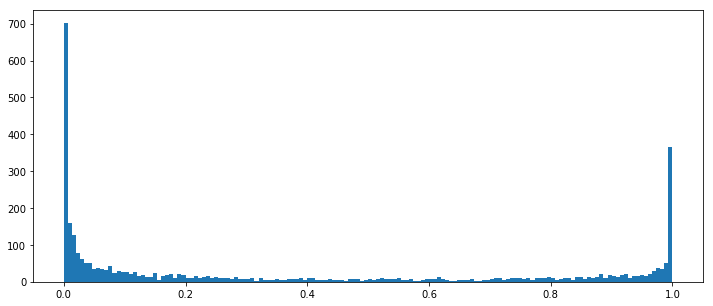

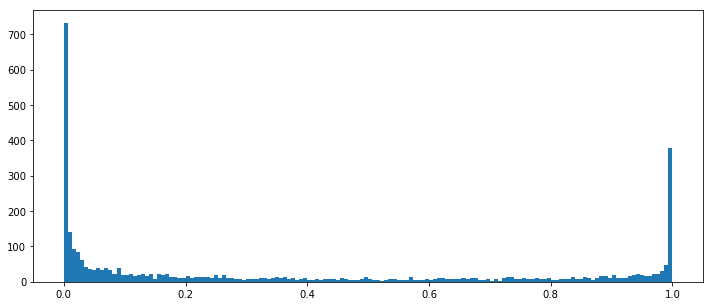

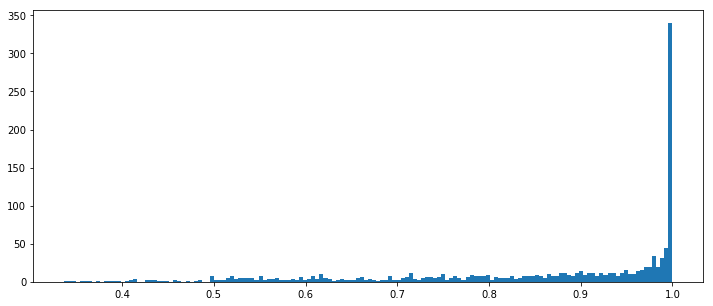

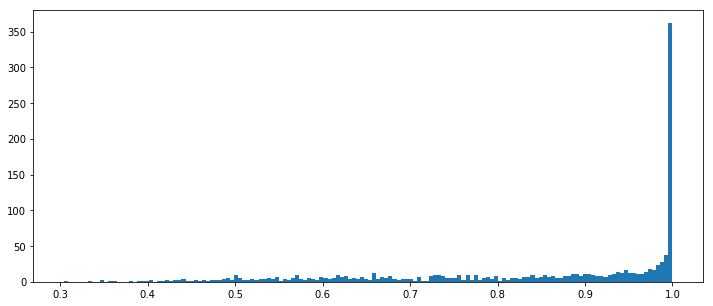

155 0.0 1.0 0.0 1.0 1e-06 1.0


In [1070]:
# Распределение результата test
ppred = pd.DataFrame()
ppred['TrackNumber'] = test.TrackNumber
ppred['pred_y'] = np.array(test_y_softmax,dtype=np.uint8)
##print(ppred.head())

tySize = ppred.groupby(['TrackNumber','pred_y']).size();
tSize  = ppred.groupby(['TrackNumber']).size();

g0pred = pd.DataFrame(np.round(tySize/tSize,4)).reset_index()   # common result table [Track#, pred#, prob]
g0pred.columns=['TrackNumber','pred_y','pr']

'''
g0pred = g0pred.set_index(['TrackNumber','pred_y']).unstack(level=-1).fillna(0.0); 
g0pred.columns=[0,1,2,3,4]
##print(g0pred.head(20)) #,g0pred.columns)
if 1 :
    for nn in g0pred.columns : g0pred[nn][g0pred[nn]<=0.05] = 0.0;
    temp     = g0pred.sum(axis=1); temp.shape #, g100pred.shape; g100pred,temp.head()
    for nn in g0pred.columns : g0pred[nn] = np.round(g0pred[nn]/temp,6);

temp = g0pred.stack().fillna(0.0)
temp = temp[temp>0.0]
g0pred = temp.reset_index()
g0pred.columns = ['TrackNumber','pred_y','pr']
'''
print('Common result \n',g0pred.head(25))

ggmax, g4pred = [], g0pred.groupby('TrackNumber')

for tt in g0pred.TrackNumber.unique().tolist() :
    aa = g4pred.get_group(tt)
    ggmax.append(aa.pred_y[aa.pr.argmax()])

##print(len(ggmax),ggmax[:40])

g1pred = pd.DataFrame(g0pred.TrackNumber.unique())   # table only one max result for Track# [Track#, pred#, prob]
g1pred['pred_y'] = np.array(ggmax)
g1pred['pr']     = 1.0
g1pred.columns=['TrackNumber','pred_y','pr']

##print 'Only result pred = 1.0 \n',g1pred.head()

g2pred = ppred.copy()
g2pred['sTime']  = testAll.sTime
g2pred['sTimeX'] = testAll.sTime.shift()
g2pred = g2pred.fillna(0)

g2pred = g2pred.groupby(['TrackNumber','pred_y']).sum();
g2pred['ssTime'] = (g2pred.sTime+g2pred.sTimeX)*0.5
ttSize = g2pred.reset_index().groupby(['TrackNumber']).sum();
g2pred['prS']  = np.round(g2pred.sTime/ttSize.sTime,6)
g2pred['prX']  = np.round(g2pred.sTimeX/ttSize.sTimeX,6)
g2pred['prSX'] = np.round(g2pred.ssTime/ttSize.ssTime,6)
g2pred['pr']   = g2pred.prSX

##print g2pred.head(20)

g3pred = g0pred.pr.groupby(g0pred.TrackNumber).max()            # max pr for each Track#
g3pred = g2pred.reset_index().prSX.groupby(g2pred.reset_index().TrackNumber).max()            # max pr for each Track#

plt.figure(figsize=(12,5)); plt.hist(g0pred.pr,bins=150); plt.show()
plt.figure(figsize=(12,5)); plt.hist(g2pred.prSX,bins=150); plt.show()

g3pred = g0pred.pr.groupby(g0pred.TrackNumber).max()            # max pr for each Track#
plt.figure(figsize=(12,5)); plt.hist(g3pred,bins=150); plt.show()
g3pred = g2pred.reset_index().prSX.groupby(g2pred.reset_index().TrackNumber).max()            # max pr for each Track#
plt.figure(figsize=(12,5)); plt.hist(g3pred,bins=150); plt.show()

print len(g3pred[g3pred<0.60]), g2pred.prS.min(), g2pred.prS.max(), g2pred.prX.min(), g2pred.prX.max(), g2pred.prSX.min(), g2pred.prSX.max()

In [1071]:
#Построение решение через probs

g100     = pd.DataFrame(test_y); g100.head(), g100.columns
g100pred = g100.groupby(ppred.TrackNumber).sum(); g100pred.head()
temp     = g100pred.sum(axis=1); temp.shape #, g100pred.shape; g100pred,temp.head()
for nn in g100pred.columns : g100pred[nn] = np.round(g100pred[nn]/temp,6);
if 0 :
    for nn in g100pred.columns : g100pred[nn][g100pred[nn]<=0.05] = 0.0;
    temp     = g100pred.sum(axis=1); temp.shape #, g100pred.shape; g100pred,temp.head()
    for nn in g100pred.columns : g100pred[nn] = np.round(g100pred[nn]/temp,6);

g100pred.head(15)

temp = g100pred.stack()
temp = temp[temp>0.0]
g100pred = pd.DataFrame(temp.reset_index());
g100pred.columns=['TrackNumber','pred_y','pr']
del temp
g100pred.head(20), g100pred.pred_y.dtype

(    TrackNumber  pred_y        pr
 0        100015       0  0.061629
 1        100015       1  0.747474
 2        100015       2  0.170305
 3        100015       3  0.020041
 4        100015       4  0.000550
 5        100045       0  0.999497
 6        100045       1  0.000001
 7        100045       2  0.000304
 8        100045       4  0.000198
 9        100060       0  0.063946
 10       100060       1  0.547817
 11       100060       2  0.387191
 12       100060       3  0.000046
 13       100060       4  0.001000
 14       100112       0  0.996450
 15       100112       1  0.000453
 16       100112       2  0.000352
 17       100112       3  0.002445
 18       100112       4  0.000300
 19       100131       0  0.832169, dtype('int64'))

In [1072]:
g110     = pd.DataFrame(test_y)
for nn in g110.columns : g110[nn] = np.round(g110[nn]*0.5*(testAll.sTime+testAll.sTime.shift().fillna(0.0)),6);
    
g110pred = g110.groupby(ppred.TrackNumber).sum(); g110pred.head()
temp     = g110pred.sum(axis=1); temp.shape #, g110pred.shape; g110pred,temp.head()
for nn in g110pred.columns : g110pred[nn] = np.round(g110pred[nn]/temp,6);
if 0 :
    for nn in g110pred.columns : g110pred[nn][g110pred[nn]<=0.05] = 0.0;
    temp     = g110pred.sum(axis=1); temp.shape #, g110pred.shape; g110pred,temp.head()
    for nn in g110pred.columns : g110pred[nn] = np.round(g110pred[nn]/temp,6);

g110pred.head(15)

temp = g110pred.stack()
temp = temp[temp>0.0]
g110pred = pd.DataFrame(temp.reset_index());
g110pred.columns=['TrackNumber','pred_y','pr']
del temp
g110pred.head(20), g110pred.pred_y.dtype

(    TrackNumber  pred_y        pr
 0        100015       0  0.128807
 1        100015       1  0.749129
 2        100015       2  0.095076
 3        100015       3  0.025529
 4        100015       4  0.001459
 5        100045       0  0.999343
 6        100045       1  0.000001
 7        100045       2  0.000467
 8        100045       4  0.000188
 9        100060       0  0.131883
 10       100060       1  0.650820
 11       100060       2  0.216371
 12       100060       3  0.000045
 13       100060       4  0.000881
 14       100112       0  0.995445
 15       100112       1  0.000962
 16       100112       2  0.000470
 17       100112       3  0.002741
 18       100112       4  0.000382
 19       100131       0  0.820084, dtype('int64'))

In [1073]:
te000 = g0pred.copy()
te100 = g100pred.copy()
te110 = g110pred.copy()

In [1074]:
#
# Построение решения из softProbs взвешенное временем до-после точки --> 874xxx
#  2 подход: -очистка, 200 раундов, отсутствие весов --> 880536.69
#  3 подход: --------  400 раундов --> 878101.38
#  4 подход: без взвешивания по времени, только среднее по точкам, 400 раундов --> 886230.54
#  5 подход: только softmax + выброс плохих точек, 400 раундов --> 885310.33
#  6 подход rolling с мелкими зачистками данных, 200 раундов --> 887014.0  2017-09-04
#  7 подход rolling с мелкими зачистками данных, 400 раундов --> 840060.63 2017-09-04
#  8 подход == 7, проверка подсчета - выключил 5% - подсчет max().sum().norm() g0pred      --> 887517.77  
#  9 подход == 7, проверка подсчета - выключил 5% - подсчет sum().max().norm() g100pred    --> 910811.59
# 10 подход == 7, проверка подсчета - выключил 5% - подсчет sum(pr*htime).max().norm() g110pred    --> 899865.96
# 11 подход подравлена загрузка, улучшен rolling - подсчет sum().max().norm() g100pred    --> 917339.22
#
#
test_r = g110pred.copy()
test_r = g100pred.copy() # 4-6 step
test_r = g0pred.copy()   # 5-8 step
test_r = g100pred.copy() #  9 step
test_r = g110pred.copy() # 10 step
test_r = g100pred.copy() # 11 step
##print(test_r.pred_y.values.tolist())
test_r['FishingType'] = np.array([y_class[x] for x in test_r.pred_y.values.tolist()])
print(test_r[['TrackNumber','FishingType','pr']].head(25))
test_r[['TrackNumber','FishingType','pr']].to_csv('../Result/bobaFish.csv',index=False,header=False)

    TrackNumber FishingType        pr
0        100015     trawler  0.061629
1        100015   longliner  0.747474
2        100015      seiner  0.170305
3        100015       other  0.020041
4        100015     support  0.000550
5        100045     trawler  0.999497
6        100045   longliner  0.000001
7        100045      seiner  0.000304
8        100045     support  0.000198
9        100060     trawler  0.063946
10       100060   longliner  0.547817
11       100060      seiner  0.387191
12       100060       other  0.000046
13       100060     support  0.001000
14       100112     trawler  0.996450
15       100112   longliner  0.000453
16       100112      seiner  0.000352
17       100112       other  0.002445
18       100112     support  0.000300
19       100131     trawler  0.832169
20       100131   longliner  0.005431
21       100131      seiner  0.001150
22       100131       other  0.158750
23       100131     support  0.002500
24       100150     trawler  0.000139


In [84]:
g0pred.head()
test_r = g0pred.copy()
##print(test_r.pred_y.values.tolist())
test_r['FishingType'] = np.array([y_class[x] for x in test_r.pred_y.values.tolist()])
print(test_r[['TrackNumber','FishingType','pr']].head(15))
test_r[['TrackNumber','FishingType','pr']].to_csv('../Result/bobaFish.csv',index=False,header=False)

    TrackNumber FishingType      pr
0        100015     trawler  0.0376
1        100015   longliner  0.8243
2        100015      seiner  0.1368
3        100015       other  0.0013
4        100045     trawler  1.0000
5        100060     trawler  0.0532
6        100060   longliner  0.7423
7        100060      seiner  0.2039
8        100060     support  0.0005
9        100112     trawler  1.0000
10       100131     trawler  0.8094
11       100131   longliner  0.0029
12       100131       other  0.1877
13       100150   longliner  0.9298
14       100150      seiner  0.0642


In [112]:
#
#  2017-09-02 Взвешенная по времени нахождения около точки (+-) вероятности типов судов
#  2017-09-02 +- хуже 886xxx -> 870xxx
#
g2pred.head()
test_r = g2pred.reset_index().copy()
test_r['pr'] = test_r.prSX
##print(test_r.pred_y.values.tolist())
test_r['FishingType'] = np.array([y_class[x] for x in test_r.pred_y.values.tolist()])
print(test_r[['TrackNumber','FishingType','pr']].head(25))
test_r[['TrackNumber','FishingType','pr']].to_csv('../Result/bobaFish.csv',index=False,header=False)

    TrackNumber FishingType        pr
0        100015     trawler  0.123381
1        100015   longliner  0.796768
2        100015      seiner  0.068208
3        100015       other  0.011644
4        100045     trawler  1.000000
5        100060     trawler  0.111688
6        100060   longliner  0.816666
7        100060      seiner  0.071583
8        100060     support  0.000063
9        100112     trawler  1.000000
10       100131     trawler  0.798129
11       100131   longliner  0.047469
12       100131       other  0.154402
13       100150   longliner  0.917904
14       100150      seiner  0.074431
15       100150     support  0.007665
16       100151     trawler  0.371117
17       100151   longliner  0.012507
18       100151      seiner  0.019218
19       100151     support  0.597159
20       100215     trawler  0.026426
21       100215   longliner  0.025318
22       100215      seiner  0.948256
23       100221     trawler  1.000000
24       100227     trawler  0.999765


In [113]:
#
#  2017-09-02 Взвешенная по времени нахождения около точки (- предыдущее время) вероятности типов судов
#  2017-09-02 - 870xxx->863xxx
#
g2pred.head()
test_r = g2pred.reset_index().copy()
test_r['pr'] = test_r.prX
##print(test_r.pred_y.values.tolist())
test_r['FishingType'] = np.array([y_class[x] for x in test_r.pred_y.values.tolist()])
print(test_r[['TrackNumber','FishingType','pr']].head(25))
test_r[['TrackNumber','FishingType','pr']].to_csv('../Result/bobaFish.csv',index=False,header=False)

    TrackNumber FishingType        pr
0        100015     trawler  0.101394
1        100015   longliner  0.837527
2        100015      seiner  0.051816
3        100015       other  0.009262
4        100045     trawler  1.000000
5        100060     trawler  0.092662
6        100060   longliner  0.848095
7        100060      seiner  0.059195
8        100060     support  0.000048
9        100112     trawler  1.000000
10       100131     trawler  0.798759
11       100131   longliner  0.047166
12       100131       other  0.154074
13       100150   longliner  0.917502
14       100150      seiner  0.075145
15       100150     support  0.007353
16       100151     trawler  0.370181
17       100151   longliner  0.014386
18       100151      seiner  0.019686
19       100151     support  0.595747
20       100215     trawler  0.048802
21       100215   longliner  0.002205
22       100215      seiner  0.948993
23       100221     trawler  1.000000
24       100227     trawler  0.999768


In [373]:
#  2017-09-01 Почему-то дает провал на 511650.89 с 890501, хотя не должна?
# Only max predictions pr<-1.0
g1pred.head()
test_r = g1pred.copy()
##print(test_r.pred_y.values.tolist())
test_r['FishingType'] = np.array([y_class[x] for x in test_r.pred_y.values.tolist()])
print(test_r[['TrackNumber','FishingType','pr']].head())
##test_r[['TrackNumber','FishingType','pr']].to_csv('../Result/bobaFish.csv',index=False,header=False)

   TrackNumber FishingType   pr
0       100015   longliner  1.0
1       100045     trawler  1.0
2       100060   longliner  1.0
3       100112     trawler  1.0
4       100131     trawler  1.0


In [42]:
##test_yy = xgbmodel.predict(mtest, pred_contribs=True)
xgb.__version__

'0.6'

In [273]:
xgbmodel.attributes()

{}

In [82]:
bbins = [aa for aa in range(49)] + [max(trainAll.hTime.max(),trainAll.hTime.max(),)+1.0]

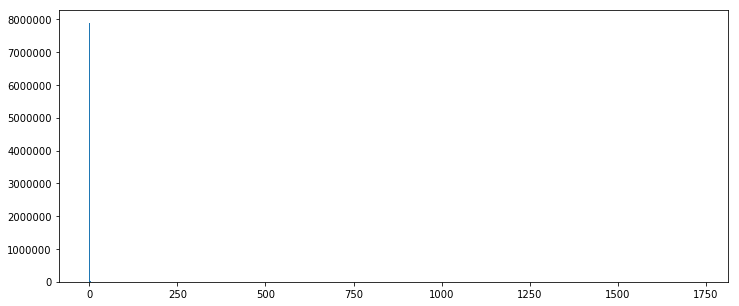

In [87]:
plt.figure(figsize=(12,5)); hh, bb, _ = plt.hist(trainAll.hTime,bins=bbins); plt.show()

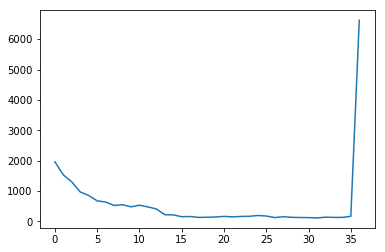

(50, 10596.0, array([  6.41767600e+06,   7.81920000e+04,   1.72610000e+04,
          1.02150000e+04,   7.46600000e+03,   6.46400000e+03,
          6.23000000e+03,   7.07300000e+03,   6.33900000e+03,
          4.01400000e+03,   2.76100000e+03,   2.11200000e+03,
          1.96100000e+03,   1.53100000e+03,   1.30000000e+03,
          9.69000000e+02,   8.53000000e+02,   6.78000000e+02,
          6.38000000e+02,   5.25000000e+02,   5.50000000e+02,
          4.81000000e+02,   5.35000000e+02,   4.78000000e+02,
          4.11000000e+02,   2.22000000e+02,   2.16000000e+02,
          1.55000000e+02,   1.63000000e+02,   1.33000000e+02,
          1.38000000e+02,   1.46000000e+02,   1.66000000e+02,
          1.51000000e+02,   1.64000000e+02,   1.69000000e+02,
          1.96000000e+02,   1.78000000e+02,   1.28000000e+02,
          1.56000000e+02,   1.35000000e+02,   1.30000000e+02,
          1.26000000e+02,   1.16000000e+02,   1.40000000e+02,
          1.33000000e+02,   1.33000000e+02,   1.69000000e

In [96]:
plt.plot(hh[12:]); plt.show()
len(bb), hh[24:].sum(), hh, bb

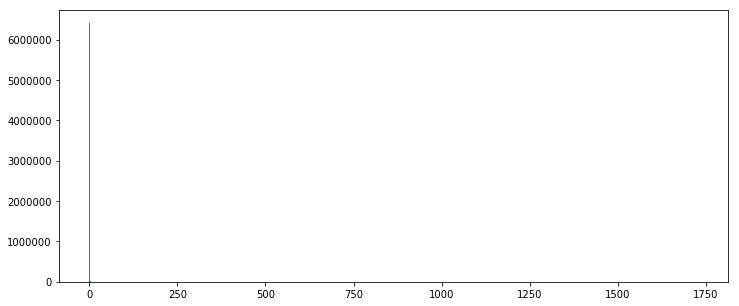

In [95]:
plt.figure(figsize=(12,5)); hh, bb, _ = plt.hist(testAll.hTime,bins=bbins); plt.show()

In [369]:
hTimeMin = 3.0/3600.0
hTimeMax = 48.0

hTimeMin = 10.0/3600.0
hTimeMax = 48.0

OKtrain = ((trainAll.hTime<=hTimeMax) & (trainAll.hTime>hTimeMin))
NOtrain = np.logical_not(OKtrain)
OKtest  = ((testAll.hTime<=hTimeMax) & (testAll.hTime>hTimeMin))
NOtest  = np.logical_not(OKtest)


print('All tracks: \ttrain={}, test={}\nTracks with wrong records:  \ttrain={}, test={}\nTracks with good records:  \ttrain={}, test={}'. \
          format(len(trainAll.TrackNumber.unique()),len(testAll.TrackNumber.unique()), \
                 len(trainAll.TrackNumber[NOtrain].unique()), \
                 len(testAll.TrackNumber[NOtest].unique()), \
                 len(trainAll.TrackNumber[OKtrain].unique()), \
                 len(testAll.TrackNumber[OKtest].unique())))

All tracks: 	train=1209, test=1211
Tracks with wrong records:  	train=1209, test=1211
Tracks with good records:  	train=1209, test=1211


In [157]:
print('train={}, test={}'.format(len(trainAll.TrackNumber[((trainAll.hTime>hTimeMax) | (trainAll.hTime<hTimeMin))]),
                                 len(testAll.TrackNumber[((testAll.hTime>hTimeMax) | (testAll.hTime<hTimeMin))] ) ))

train=938990, test=658466


In [133]:
train[train.hTime> 48.0]

,TrackNumber,Chlorophyll Concentration,Depth,Distance,Eastward Water Velocity,Latitude,Longitude,Northward Water Velocity,Oceanic Depth,SOG,...,Sea Temperature,Speed,Thermocline Depth,Time,Time(seconds),Water Surface Elevation,hTime,oceanic depth,sTime,y
69,100047,0.3114,-4,0.635781,-0.04,41.099857,1.232748,-0.03,NaN,8.9,...,10.6,0.005562,113.6,210835,210835,-0.21,61.726111,-4.0,222214.0,0
93,100047,0.3095,-5,0.905187,-0.21,41.107890,1.238818,-0.10,NaN,0.0,...,10.2,0.004476,123.8,643825,643825,-0.19,109.190278,-5.0,393085.0,0
179,100047,0.3043,-10,3.923416,-0.04,41.078055,1.213548,0.01,NaN,10.6,...,9.9,0.034441,263.1,1420301,1420301,-0.17,61.510556,-10.0,221438.0,0
251,100047,0.3043,-10,2.912001,0.10,41.082810,1.215468,0.04,NaN,10.7,...,9.8,0.025526,323.8,2024705,2024705,-0.21,61.597778,-10.0,221752.0,0
297,100047,0.3092,-5,3.436802,0.05,41.104813,1.239307,0.11,NaN,0.5,...,9.6,0.029979,157.6,2629425,2629425,-0.29,61.900000,-5.0,222840.0,0
359,100047,0.2080,-4,2.703458,-0.06,41.088820,1.221198,0.05,NaN,9.4,...,9.6,0.023528,252.4,3232398,3232398,-0.30,62.043333,-4.0,223356.0,0
418,100047,0.2047,-5,0.207280,-0.12,41.108707,1.240357,0.29,NaN,0.0,...,9.6,0.001338,380.1,3759683,3759683,-0.23,83.626111,-5.0,301054.0,0
453,100047,0.2042,-5,2.327180,-0.12,41.104318,1.241150,0.17,NaN,0.8,...,9.7,0.020191,184.3,4442169,4442169,-0.24,62.235278,-5.0,224047.0,0
473,100047,0.2092,-3,0.086283,0.00,41.083383,1.215767,0.10,NaN,7.3,...,9.9,0.000745,252.4,5046051,5046051,-0.25,62.506389,-3.0,225023.0,0
495,100047,0.1735,-5,3.308095,-0.02,41.105027,1.242002,0.18,NaN,8.4,...,9.8,0.028623,229.6,5651446,5651446,-0.26,62.406389,-5.0,224663.0,0


In [714]:
# Смотрим статистику по судам

True : [569.0, 193.0, 266.0, 53.0, 128.0] 

Train: [572.837, 189.484, 266.883, 49.756, 130.041]
Train: [575.115, 187.272, 265.228, 48.658, 132.727]
Train: [574.706, 185.916, 264.168, 48.01, 136.201]

Test : [584.974, 194.675, 274.295, 33.745, 123.313]
Test : [576.366, 196.283, 274.782, 36.338, 127.231]
Test : [574.318, 201.913, 272.546, 37.461, 124.761]


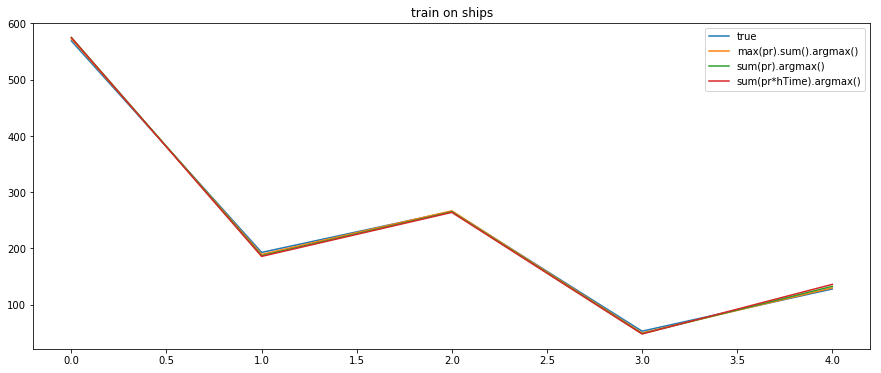

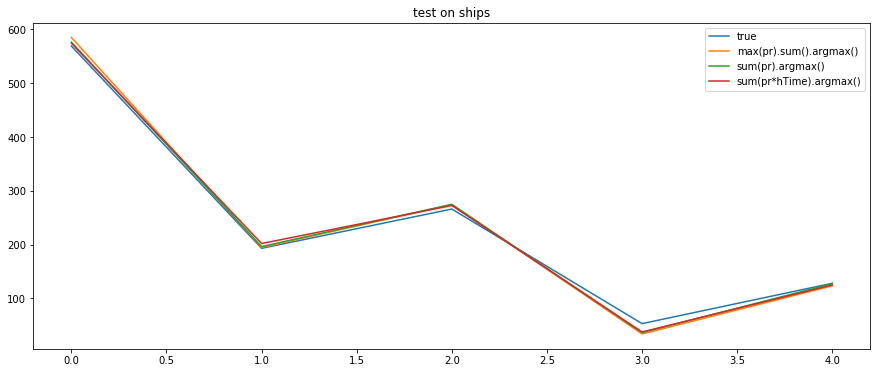

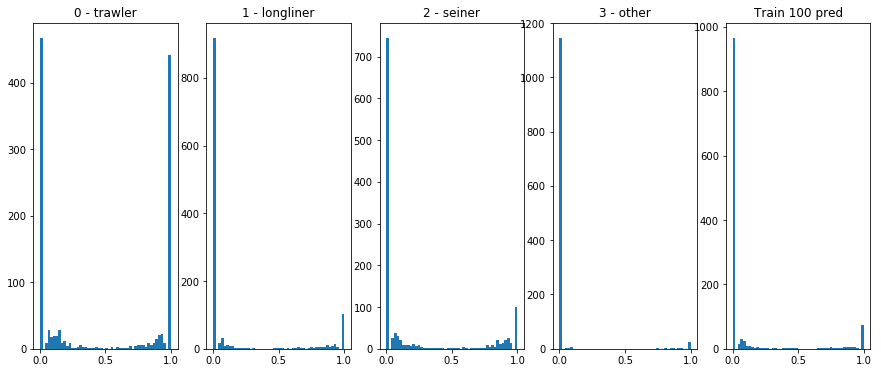

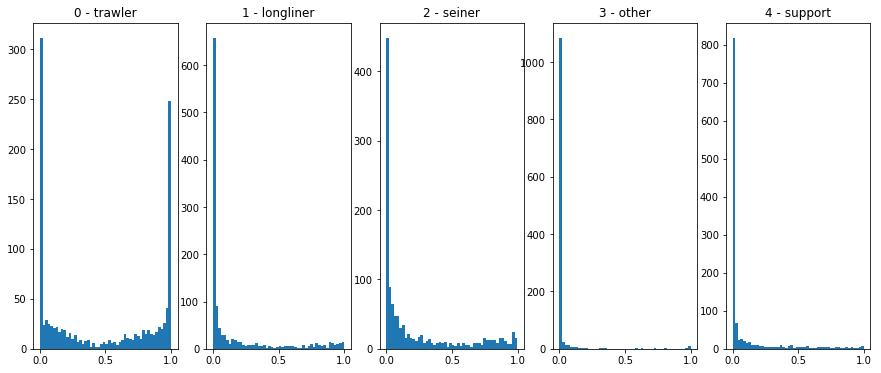

In [813]:
def pr1x5 (df) :
    temp = df.set_index(['TrackNumber','pred_y']).unstack().fillna(0.0)
    temp.columns=[0,1,2,3,4]
    return(temp)
    
train_stat = gg[['TrackNumber','pred_y','true_y']];
##print(gg.head())
#plt.hist()
train_true = train_stat.set_index(['TrackNumber','pred_y']).unstack().fillna(0.0)
train_true.columns=[0,1,2,3,4]

print 'True :', pr1x5(train_stat).sum().tolist(),'\n'

print 'Train:',np.round(pr1x5(tr000).sum(),3).tolist()
print 'Train:',np.round(np.array(pr1x5(tr100).sum(),dtype=np.float),3).tolist()
print 'Train:',np.round(pr1x5(tr110).sum(),3).tolist()
print
print 'Test :',np.round(pr1x5(te000).sum(),3).tolist()
print 'Test :',np.round(np.array(pr1x5(te100).sum(),dtype=np.float),3).tolist()
print 'Test :',np.round(pr1x5(te110).sum(),3).tolist()

plt.figure(figsize=(15,6))
plt.plot(pr1x5(train_stat).sum()); 
plt.plot(pr1x5(tr000).sum()); 
plt.plot(pr1x5(tr100).sum()); 
plt.plot(pr1x5(tr110).sum()); 

plt.legend(['true', 'max(pr).sum().argmax()', 'sum(pr).argmax()', 'sum(pr*hTime).argmax()'])

plt.title('train on ships')
plt.show()

plt.figure(figsize=(15,6))
plt.plot(pr1x5(train_stat).sum()); 
plt.plot(pr1x5(te000).sum()); 
plt.plot(pr1x5(te100).sum()); 
plt.plot(pr1x5(te110).sum()); 

plt.legend(['true', 'max(pr).sum().argmax()', 'sum(pr).argmax()', 'sum(pr*hTime).argmax()'])

plt.title('test on ships')
plt.show()

plt.figure(figsize=(15,6))
temp = pr1x5(tr100)
for ii,nn in enumerate(temp.columns) :
    plt.subplot(1,temp.shape[1],ii+1); plt.hist(temp[nn],bins=50);plt.title(str(nn)+" - "+y_class[ii])
plt.title('Train 100 pred')
plt.show()

plt.figure(figsize=(15,6))
temp = pr1x5(te100)

for ii,nn in enumerate(temp.columns) :
    plt.subplot(1,temp.shape[1],ii+1); plt.hist(temp[nn],bins=50);plt.title(str(nn)+" - "+y_class[ii])
plt.show()

plt.close()
#g0pred.head()

In [954]:
def plot_trass_fl (df) :
    plt.plot(df['Longitude'].values.tolist(),df['Latitude'].values.tolist());
    plt.show();
def plot_trass_sp (df) :
    plt.plot(df['SOG']);    legenda  = ['SOG']
    plt.plot(df['rSOG']);   legenda += ['rSOG']
    plt.plot(df['rSpeed']); legenda += ['rSpeed']
    #plt.plot(df['rDTSpeed']); legenda += ['rDTSpeed']
    #plt.plot(df['Speed']); legenda += ['Speed']
    plt.legend(legenda)
    plt.show();

def plot_dist (df) :
    plt.plot(df['Distance'].cumsum());    legenda  = ['Distance']
    plt.legend(legenda)
    plt.show();
    
def plot_hours (df) :
    plt.plot(df['hTime'].cumsum());    legenda  = ['hTime']
    plt.legend(legenda)
    plt.show();
                
def plot_dh (df) :
    plt.plot(df['hTime'].cumsum().values.tolist(),df['Distance'].cumsum().values.tolist());
    plt.show();


In [1009]:
# Построение массива с данными по списку файлов

def buildX (file_list, nFiles=-1, maxSpeed=35.0, maxSOG=35.0, rWindow=5, hTimeMin=False, hTimeMax=False, fillOK=False) :
    
    
    for ii,ffile in enumerate(file_list) :
        if ii==nFiles : break
        xx = pd.read_csv(os.path.join('../Data/VesselTracks',str(ffile)+'.csv'))
        
        ##print(ii,ffile)
        
        # Small corrections: (latitude&longitude), timing
        
        xx = xx[(xx.Latitude >=-90.0)  & (xx.Latitude <= 90.0)];
        xx = xx[(xx.Longitude>=-180.0) & (xx.Longitude<=180.0)];
        
        xx['Time']  = xx[[1]]
        xx['sTime'] = np.abs(xx.Time.diff(-1)).fillna(0.0)
        xx['hTime'] = xx.sTime/3600.0
        
        if hTimeMin : 
            xx          = xx[xx.hTime>=hTimeMin]
            xx['sTime'] = np.abs(xx.Time.diff(-1)).fillna(0.0)
            xx['hTime'] = xx.sTime/3600.0
            
        havLa       = (0.5*(1.0-np.cos(-xx.Latitude.diff(-1)/180.0*math.pi))).fillna(0.0)
        lLongitude  = xx.Longitude+360.0
        havLo       = (0.5*(1.0-np.cos(-lLongitude.diff(-1)/180.0*math.pi))).fillna(0.0)

        cosLa       = (np.cos(xx.Latitude/180.0*math.pi)).fillna(0.0)

        hav         = (havLa+cosLa*cosLa.shift(-1)*havLo).fillna(0.0)
        dist = (2*6371.0*np.arcsin(np.sqrt(hav))).fillna(0.0)

        xx['Distance'] = dist
        xx['Speed']    = np.round((dist/1.852/xx.hTime).fillna(0.0),2)
        xx.loc[xx.Speed>maxSpeed,'Speed'] = maxSpeed
        
        if hTimeMax : 
            xx.sTime[xx.hTime<=hTimeMax] = 0.0
            xx.hTime[xx.hTime<=hTimeMax] = 0.0
        
        # rolling Speed
        rSOG      = xx.SOG.rolling(window=rWindow, min_periods=1).mean()
        rSOGmd    = xx.SOG.rolling(window=rWindow, min_periods=1).median()
        rSpeed    = xx.Speed.rolling(window=rWindow, min_periods=1).mean()
        rDistance = xx.Distance.rolling(window=rWindow, min_periods=1).mean()
        rTime     = xx.hTime.rolling(window=rWindow, min_periods=1).mean()
        rDTSpeed = (rDistance/rTime/1.852).fillna(0.0)
        
        xx['rSpeed'] = np.round(np.clip(rSpeed,0.0,maxSpeed),2)
        xx['rSOG']   = np.round(np.clip(rSOG,0.0,maxSpeed),2)
        xx['rSOGmd'] = np.round(np.clip(rSOGmd,0.0,maxSpeed),2)
        xx['rDTSpeed'] = np.round(np.clip(rDTSpeed,0.0,maxSpeed),2)
        
        xx.loc[xx.SOG>maxSOG,'SOG'] = xx.loc[xx.SOG>maxSOG,'rSOG']
        xx.loc[xx.SOG<0.0,'SOG']    = xx.loc[xx.SOG<0.0,'rSOG']

        if fillOK : xx = xx.fillna(fillOK)

        if (ii==0) : resAll = xx.copy()
        else       : resAll = resAll.append(xx.copy())

    ##print(trainAll.shape)
    return (resAll)

def buildY (file_list, y_classes) :
    
    trainIndex=file_list.copy()
    trainIndex['y'] = np.array(map(y_classes.index,trainIndex.typing.tolist()))
    return(trainIndex)

In [1010]:
def plotting(inns,trackIndex,trainAll_) :
    
    for inn in inns.values.tolist() :

        nn   = trainIndex.loc[trainIndex.trackfile==inn,'typing'].values
        temp = trainAll_.loc[trainAll_.TrackNumber==inn]

        print('*'*90)
        print(str(inn)+' - '+nn, '-'*40)
        print('Distance: {} hTime: {} Distance(max)={}'.format(temp['Distance'].sum(),temp['hTime'].sum(),temp['Distance'].max()))
        print('SOG: \tmean={} median={} minmax = {}-{}'.format(temp['SOG'].mean(),temp['SOG'].median(),temp['SOG'].min(),temp['SOG'].max()))
        print('rSOG: \tmean={} median={} minmax = {}-{}'.format(temp['rSOG'].mean(),temp['rSOG'].median(),temp['rSOG'].min(),temp['rSOG'].max()))
        print('Speed: \tmean={} median={} minmax = {}-{}'.format(temp['Speed'].mean(),temp['Speed'].median(),temp['Speed'].min(),temp['Speed'].max()))
        print('rSp: \tmean={} median={} minmax = {}-{}'.format(temp['rSpeed'].mean(),temp['rSpeed'].median(),temp['rSpeed'].min(),temp['rSpeed'].max()))
        plt.figure(figsize=(15,5)); plt.title(str(inn)+' - '+nn); plot_trass_sp(temp)

        plt.figure(figsize=(15,3)); plt.title(str(inn)+' - '+nn); plot_trass_fl(temp)

        plt.figure(figsize=(15,3)); plt.title(str(inn)+' - '+nn); plot_dh(temp)

        #plt.figure(figsize=(15,5)); plt.title(str(inn)+' - '+nn); plot_dist(temp)
        #plt.figure(figsize=(15,5)); plt.title(str(inn)+' - '+nn); plot_hours(temp)

In [1011]:
trainAll_ = buildX(train_list['trackfile'].values.tolist(), nFiles=101, hTimeMin=5.0/3600, rWindow=5);

   trackfile     typing  y
0     100047    trawler  0
1     100070  longliner  1
2     100080     seiner  2
3     100093      other  3
4     100144    trawler  0
(193, [100070, 100161, 100362, 100453, 100488, 100528, 100625, 100703, 100854, 100996, 101096, 101329, 101947, 102357, 102408, 102424, 102455, 102508, 102519, 102651])
******************************************************************************************
(array(['100070 - longliner'], dtype=object), '----------------------------------------')
Distance: 2450.31900058 hTime: 2125.73916667 Distance(max)=152.67953727
SOG: 	mean=8.17886597938 median=9.1 minmax = 0.0-10.6
rSOG: 	mean=8.15533505155 median=9.08 minmax = 0.2-10.22
Speed: 	mean=7.62530927835 median=9.125 minmax = 0.0-15.41
rSp: 	mean=7.61528350515 median=8.665 minmax = 0.26-10.36


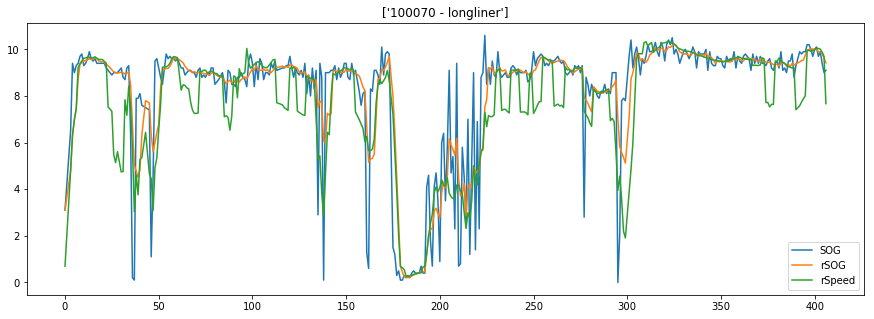

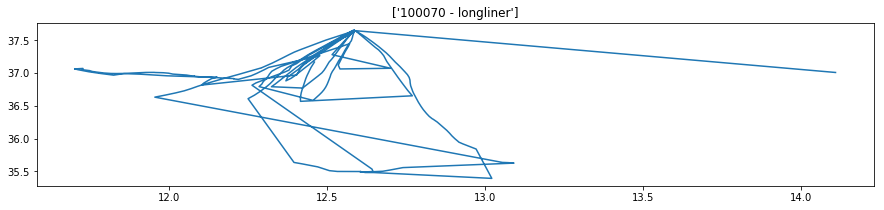

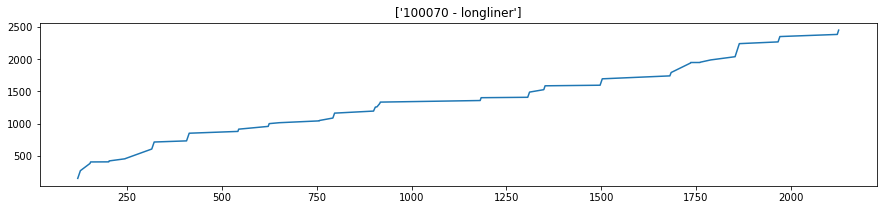

******************************************************************************************
(array(['100161 - longliner'], dtype=object), '----------------------------------------')
Distance: 12827.6916386 hTime: 2183.99805556 Distance(max)=3955.96584389
SOG: 	mean=1.20218403151 median=0.0 minmax = 0.0-10.6
rSOG: 	mean=1.19857500895 median=0.0 minmax = 0.0-9.94
Speed: 	mean=1.22397064089 median=0.01 minmax = 0.0-35.0
rSp: 	mean=1.22204797709 median=0.01 minmax = 0.0-14.02


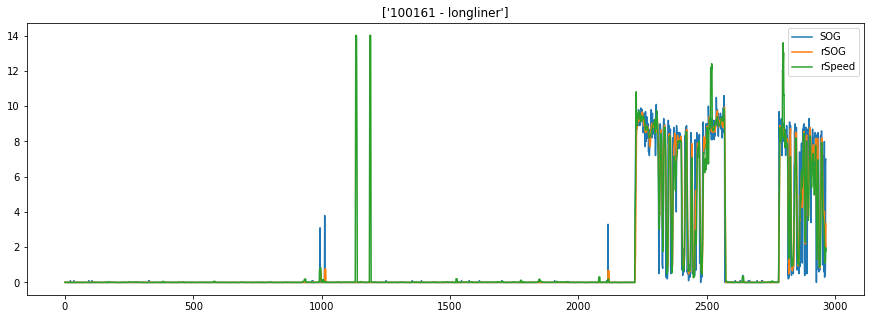

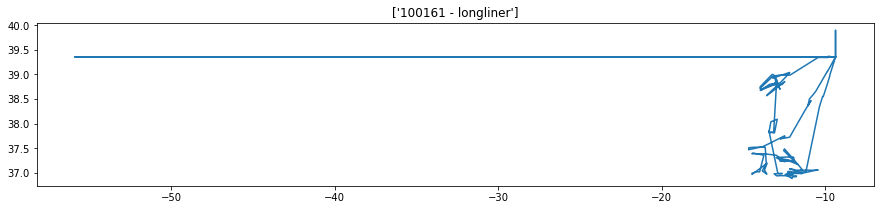

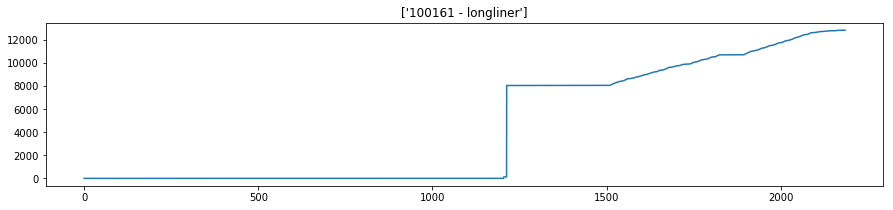

******************************************************************************************
(array(['100362 - longliner'], dtype=object), '----------------------------------------')
Distance: 723.201041587 hTime: 1396.72138889 Distance(max)=78.6476257983
SOG: 	mean=7.68709677419 median=7.9 minmax = 0.0-9.0
rSOG: 	mean=7.68703225806 median=7.88 minmax = 0.0-8.84
Speed: 	mean=7.00825806452 median=7.93 minmax = 0.0-9.68
rSp: 	mean=6.97916129032 median=7.76 minmax = 0.0-9.01


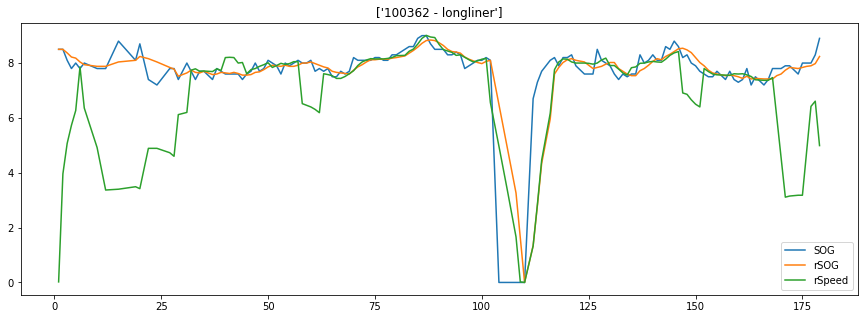

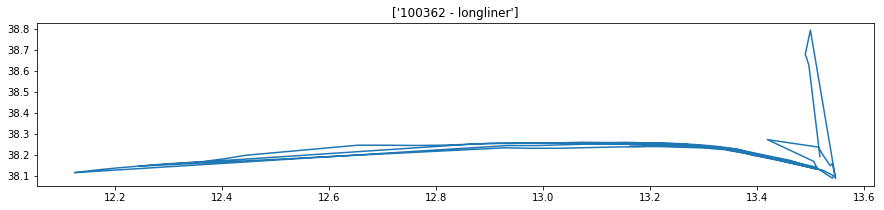

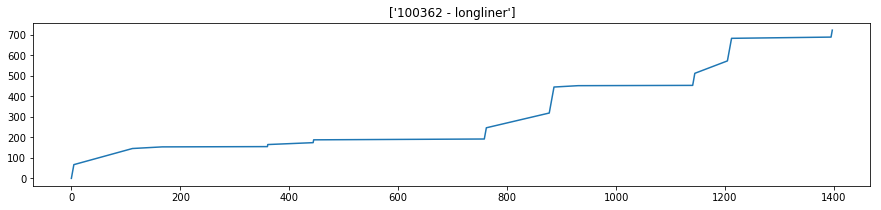

******************************************************************************************
(array(['100453 - longliner'], dtype=object), '----------------------------------------')
Distance: 17296.1163262 hTime: 2207.39333333 Distance(max)=526.845623578
SOG: 	mean=5.28793544578 median=6.3 minmax = 0.0-10.5
rSOG: 	mean=5.28798268057 median=5.98 minmax = 0.0-9.86
Speed: 	mean=5.18177327298 median=6.12 minmax = 0.0-10.98
rSp: 	mean=5.18154497146 median=5.72 minmax = 0.0-9.78


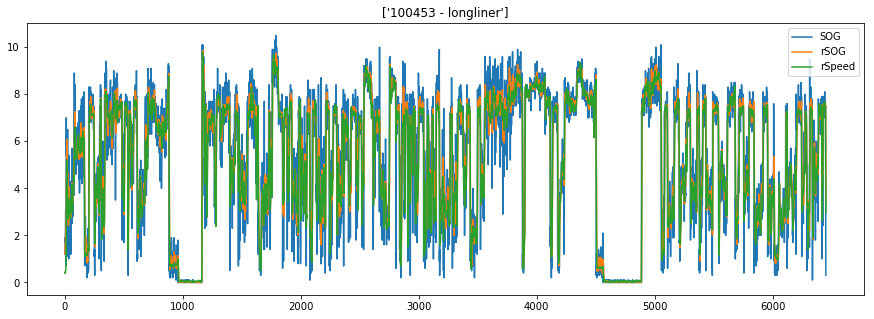

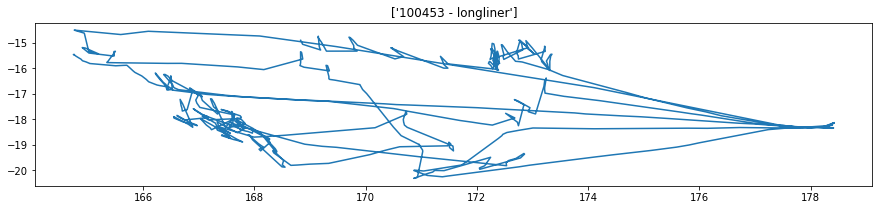

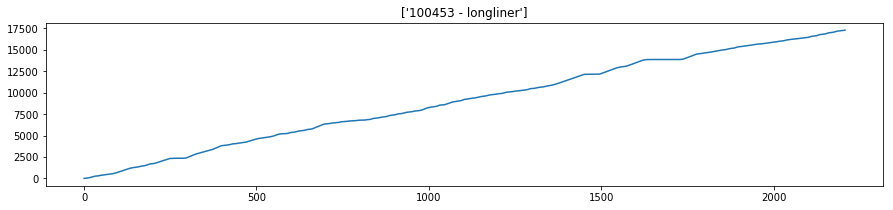

******************************************************************************************
(array(['100488 - longliner'], dtype=object), '----------------------------------------')
Distance: 10209.7152459 hTime: 2140.71083333 Distance(max)=1760.3344709
SOG: 	mean=5.19324055666 median=6.1 minmax = 0.0-9.1
rSOG: 	mean=5.1416500994 median=5.44 minmax = 0.0-8.14
Speed: 	mean=4.62662027833 median=5.61 minmax = 0.0-9.05
rSp: 	mean=4.62908548708 median=4.92 minmax = 0.03-7.96


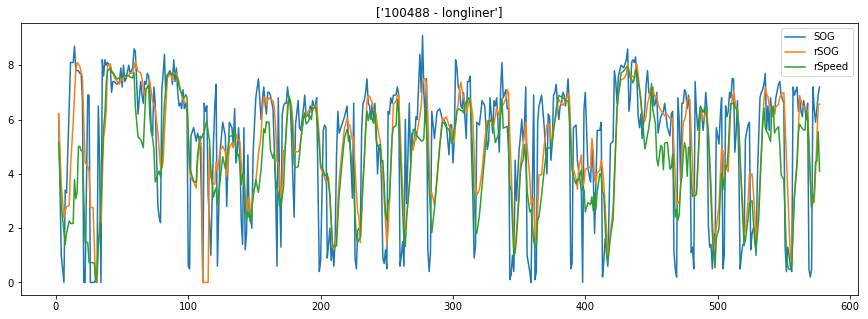

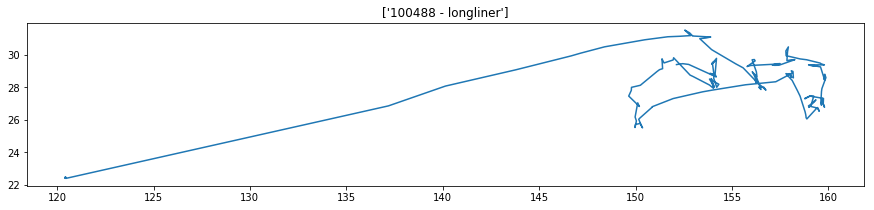

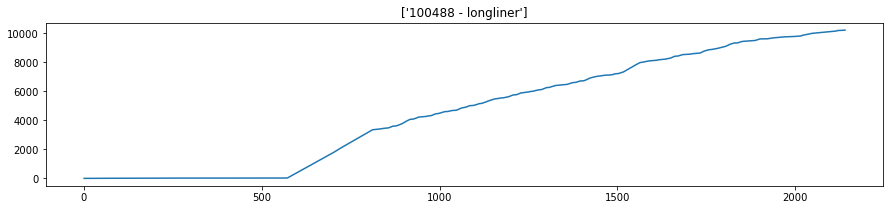

******************************************************************************************
(array(['100528 - longliner'], dtype=object), '----------------------------------------')
Distance: 6808.23357359 hTime: 1910.09611111 Distance(max)=1555.63136843
SOG: 	mean=1.94764512596 median=0.1 minmax = 0.0-10.3
rSOG: 	mean=1.94170865279 median=0.32 minmax = 0.0-9.9
Speed: 	mean=1.80446878423 median=0.15 minmax = 0.0-35.0
rSp: 	mean=1.8010332238 median=0.26 minmax = 0.0-15.46


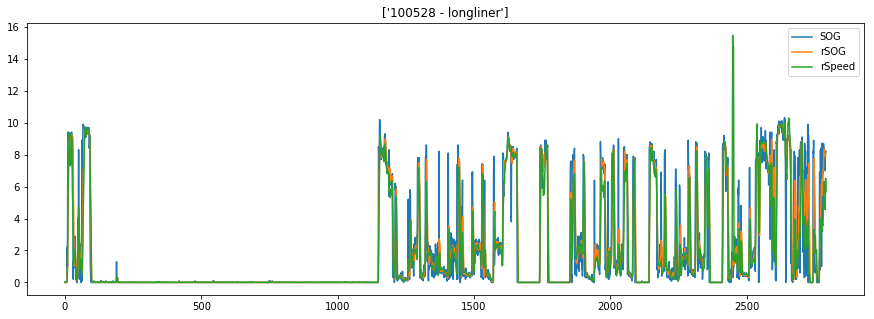

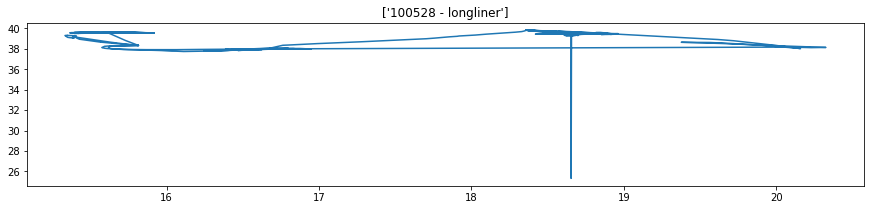

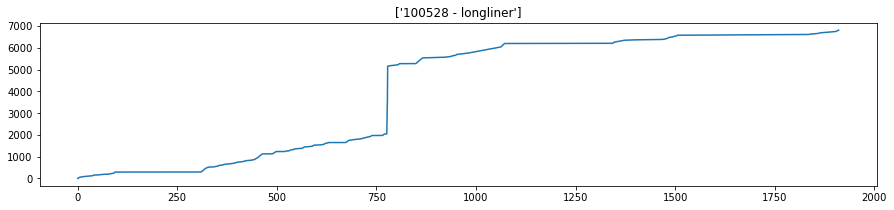

******************************************************************************************
(array(['100625 - longliner'], dtype=object), '----------------------------------------')
Distance: 47178.9653501 hTime: 2125.19833333 Distance(max)=4469.64108685
SOG: 	mean=0.76178476134 median=0.3 minmax = 0.0-9.6
rSOG: 	mean=0.761141417136 median=0.32 minmax = 0.0-9.4
Speed: 	mean=1.02993181144 median=0.3 minmax = 0.0-35.0
rSp: 	mean=1.02946042099 median=0.31 minmax = 0.0-21.0


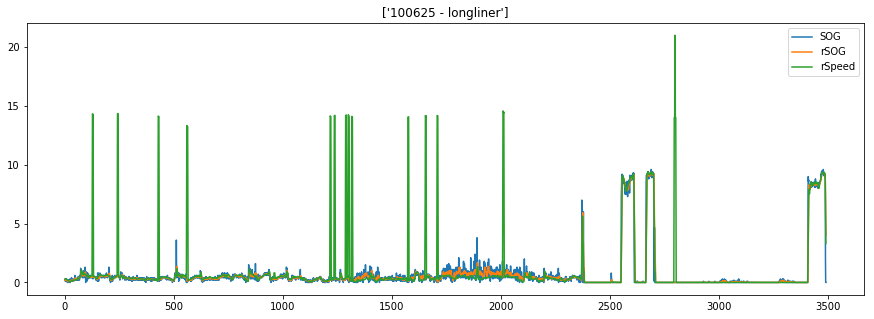

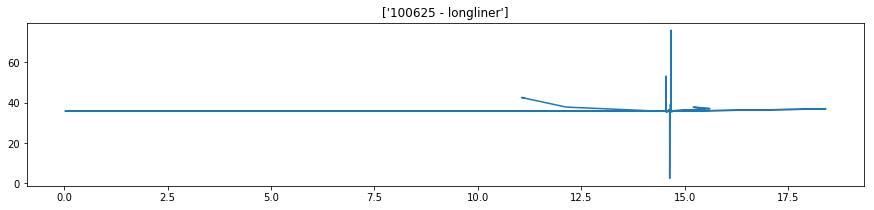

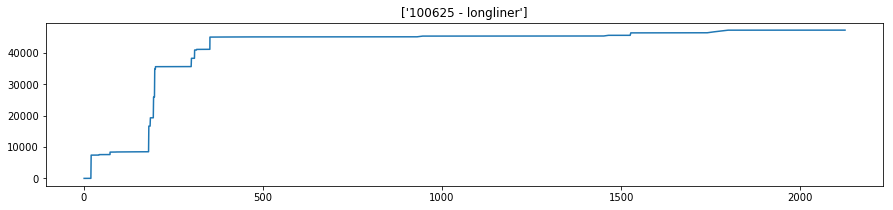

******************************************************************************************
(array(['100703 - longliner'], dtype=object), '----------------------------------------')
Distance: 58.6732981872 hTime: 37.6138888889 Distance(max)=4.8611295969
SOG: 	mean=5.44230769231 median=8.05 minmax = 0.0-9.0
rSOG: 	mean=4.80307692308 median=7.45 minmax = 0.0-8.68
Speed: 	mean=5.21 median=8.325 minmax = 0.0-8.72
rSp: 	mean=4.82807692308 median=6.805 minmax = 0.0-8.65


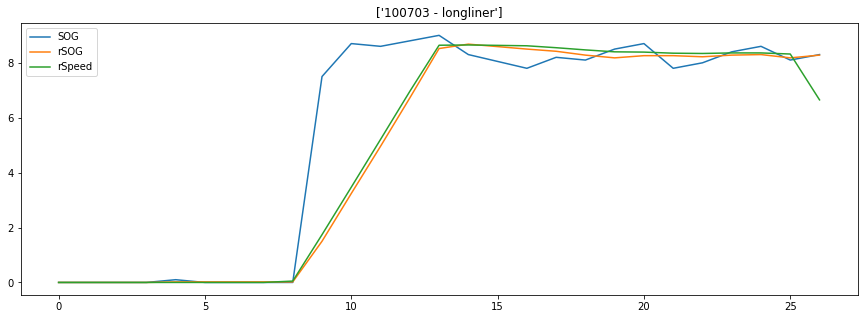

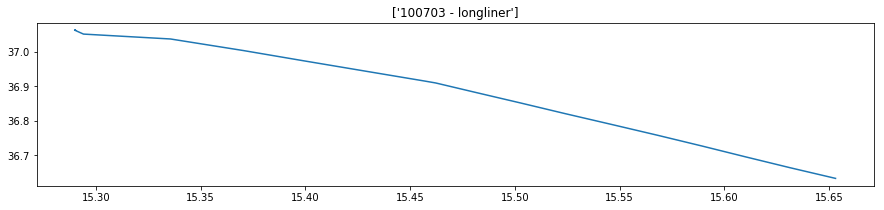

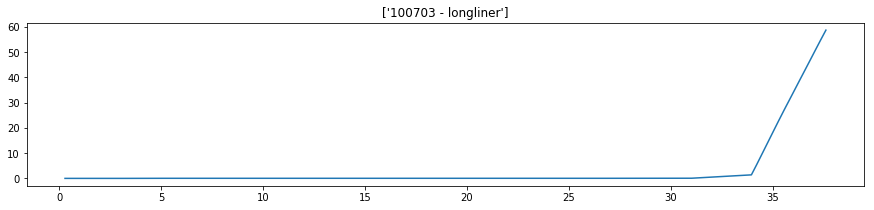

******************************************************************************************
(array(['100854 - longliner'], dtype=object), '----------------------------------------')
Distance: 2580.11605431 hTime: 1873.81666667 Distance(max)=908.575876239
SOG: 	mean=2.17815533981 median=0.0 minmax = 0.0-10.0
rSOG: 	mean=2.14067961165 median=0.0 minmax = 0.0-9.32
Speed: 	mean=2.02077669903 median=0.01 minmax = 0.0-9.9
rSp: 	mean=1.99783980583 median=0.01 minmax = 0.0-8.84


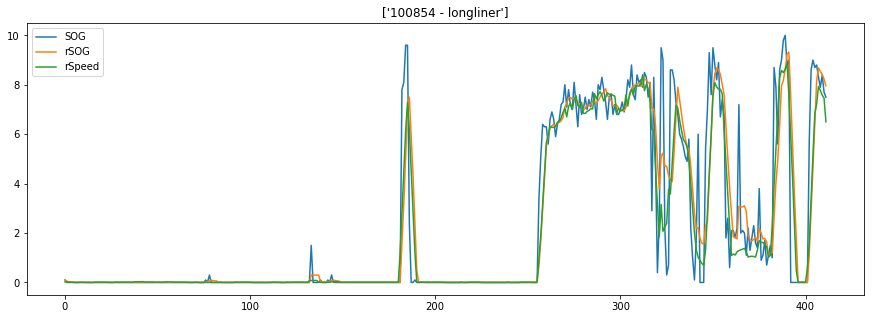

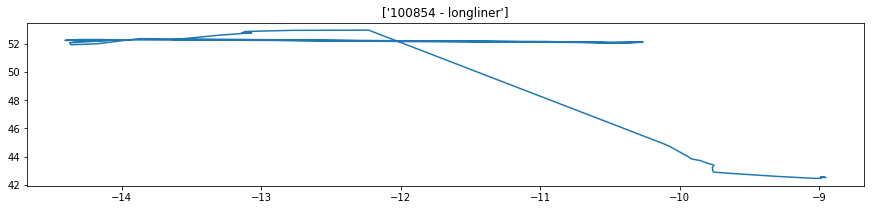

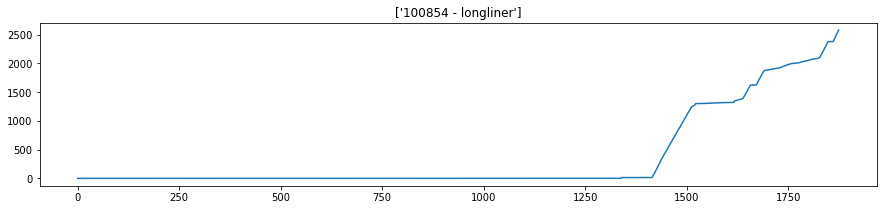

******************************************************************************************
(array(['100996 - longliner'], dtype=object), '----------------------------------------')
Distance: 10524.9571352 hTime: 2173.605 Distance(max)=824.38191736
SOG: 	mean=3.14232424677 median=0.0 minmax = 0.0-9.8
rSOG: 	mean=3.14050215208 median=0.04 minmax = 0.0-9.56
Speed: 	mean=2.86665710187 median=0.01 minmax = 0.0-9.97
rSp: 	mean=2.87586800574 median=0.16 minmax = 0.0-9.63


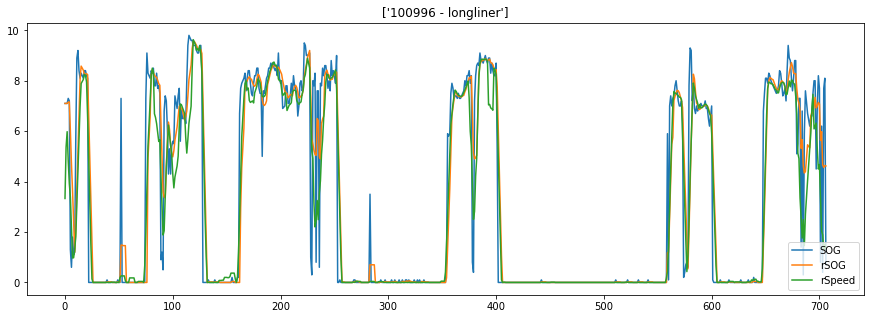

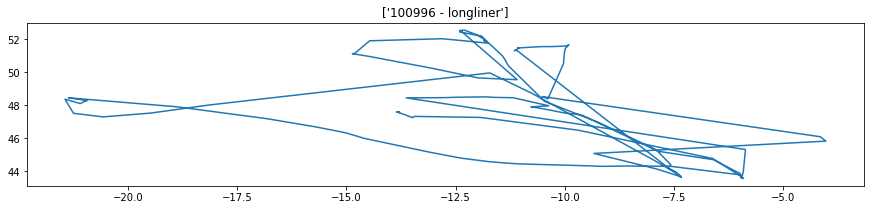

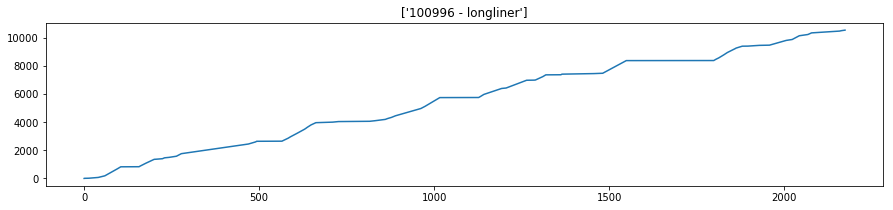

In [1013]:
trainAll.TrackNumber.head()
print(trainIndex.head())
inns = trainIndex[trainIndex.y==1].trackfile
print(len(inns),inns.head(20).values.tolist())
plotting(inns[:10],trainIndex,trainAll_)

In [960]:
8000.0/(14*1.852)/24.0

12.856114367993419

In [999]:
2*math.pi*6371

40030.173592041145